In [ ]:
# !python src/scripts/json_to_parquet.py
# !python src/scripts/sport_videos.py

In [ ]:
import os
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from src.utils.data_utils import get_related_videos_with_keywords
from src.utils.general_utils import plot_wordcloud
from src.utils.evaluation_utils import diff_in_diff

# supress all warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
DATA_PATH = "./data"

In this notebook, we start with cleaning and comprehensive exploration of the dataset in Part 0 to ensure a thorough understanding of its structure and content. In the following sections, we conduct some basis analyses to assess the feasibility of our proposed methods. We will delve deeper into these analyses in Milestone 3.

# Part 0: Get to know the dataset

In the YouNiverse dataset, we are given 4 main types of data:
- Video data
- Channel data 
- Timeseries data about the increasing number of subscribers, videos and views of channels
- Comment data 

We will explore each data seperately and then combine them to get some insights.

In [3]:
# Load channel dataset
df_ch_f = pd.read_csv(
    os.path.join(DATA_PATH, "df_channels_en.tsv"), 
    compression="infer", 
    sep="\t"
)
df_ch_f["join_date"] = pd.to_datetime(df_ch_f["join_date"])

In [4]:
# Load timeseries dataset
df_ts_f = pd.read_csv(
    os.path.join(DATA_PATH, "df_timeseries_en.tsv.gz"), 
    compression="infer", 
    sep="\t"
)
df_ts_f["datetime"] = pd.to_datetime(df_ts_f["datetime"])

In [5]:
# Load video dataset without descriptions and tags
df_vd_f = pd.read_feather(
    os.path.join(DATA_PATH, "yt_metadata_helper.feather")
)

In [7]:
# Load comment dataset
# The dataset is too large to load at once, so in this part, we load only the first 100 million rows.
df_co_f = pd.read_csv(
    os.path.join(DATA_PATH, "youtube_comments.tsv.gz"), 
    compression="infer", 
    sep="\t", 
    nrows=100_000_000 # 8_600_000_000 (full dataset)
)

## Video data

In [11]:
# overview
df_vd_f.head()

categories                channel_id  dislike_count   display_id  \
0  Film & Animation  UCzWrhkg9eK5I8Bm3HfV-unA            1.0  SBqSc91Hn9g   
1  Film & Animation  UCzWrhkg9eK5I8Bm3HfV-unA            1.0  UuugEl86ESY   
2  Film & Animation  UCzWrhkg9eK5I8Bm3HfV-unA          779.0  oB4c-yvnbjs   
3  Film & Animation  UCzWrhkg9eK5I8Bm3HfV-unA           24.0  ZaV-gTCMV8E   
4  Film & Animation  UCzWrhkg9eK5I8Bm3HfV-unA           13.0  cGvL7AvMfM0   

   duration  like_count upload_date  view_count  
0      1159         8.0  2016-09-28      1057.0  
1      2681        23.0  2016-09-28     12894.0  
2      1394      1607.0  2016-09-28   1800602.0  
3      5064       227.0  2016-09-28     57640.0  
4      3554       105.0  2016-09-28     86368.0

In [12]:
# Examine NaN values
print("Number of NaN values in each column:")
print(df_vd_f.isnull().sum())

Number of NaN values in each column:
categories             0
channel_id             0
dislike_count    1631458
display_id             0
duration               0
like_count       1631458
upload_date            0
view_count           654
dtype: int64


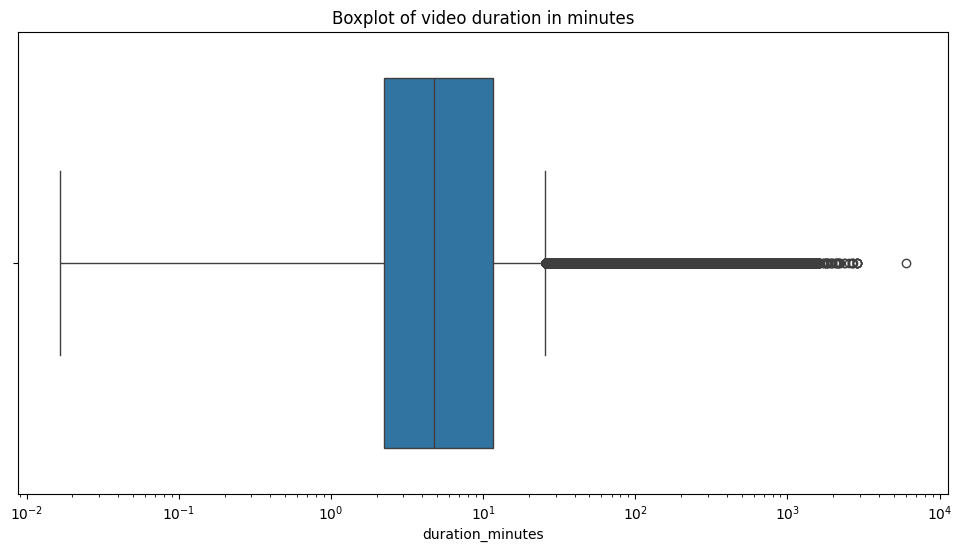

In [13]:
# Boxplot of video duration
df_vd_f["duration_minutes"] = df_vd_f["duration"].apply(lambda x: x/60)

plt.figure(figsize=(12, 6))
sns.boxplot(x="duration_minutes", data=df_vd_f)
plt.title("Boxplot of video duration in minutes")
plt.xscale("log")
plt.show()

## Channel data

In [14]:
# overview
df_ch_f.head(10)

category_cc  join_date                   channel  \
0         Gaming 2010-04-29  UC-lHJZR3Gqxm24_Vd_AJ5Yw   
1      Education 2006-09-01  UCbCmjCuTUZos6Inko4u57UQ   
2  Entertainment 2006-09-20  UCpEhnqL0y41EpW2TvWAHD7Q   
3  Howto & Style 2016-11-15  UC295-Dw_tDNtZXFeAPAW6Aw   
4         Sports 2007-05-11  UCJ5v_MCY6GNUBTO8-D3XoAg   
5  Entertainment 2007-01-15  UCIwFjwMjI0y7PDBVEO9-bkQ   
6          Music 2014-03-12  UCFFbwnve3yF62-tVXkTyHqg   
7         Sports 2009-03-17  UCRijo3ddMTht_IHyNSNXpNQ   
8  Entertainment 2015-05-12  UCk8GzjMOrta8yxDcKfylJYw   
9          Music 2006-08-08  UC0C-w0YjGpqDXGB8IHb662A   

                   name_cc  subscribers_cc  videos_cc  subscriber_rank_sb  \
0                PewDiePie       101000000       3956                 3.0   
1  Cocomelon - Nursery ...        60100000        458                 7.0   
2                SET India        56018869      32661                 8.0   
3          5-Minute Crafts        60600000       3591                 9.0   
4                      WWE        48400000      43421                11.0   
5            Justin Bieber        46574085        134                12.0   
6        Zee Music Company        43451109       4241                13.0   
7             Dude Perfect        45800000        213                14.0   
8        ✿ Kids Diana Show        34700000        599                16.0   
9               Ed Sheeran        42000000        154                17.0   

   weights  
0    2.087  
1    2.087  
2    2.087  
3    2.087  
4    2.087  
5    2.087  
6    2.087  
7    2.087  
8    2.087  
9    2.087

In [15]:
# Examine NaN values
print("Number of NaN values in each column:")
print(df_ch_f.isnull().sum())

Number of NaN values in each column:
category_cc           128
join_date               1
channel                 0
name_cc                10
subscribers_cc          0
videos_cc               0
subscriber_rank_sb      0
weights                 0
dtype: int64


In [16]:
# Check channel with join_date NaN
df_ch_f[df_ch_f["join_date"].isnull()]

category_cc join_date                   channel  name_cc  \
62  Entertainment       NaT  UCBR8-60-B28hp2BmDPdntcQ  YouTube   

    subscribers_cc  videos_cc  subscriber_rank_sb  weights  
62        28200000        301               110.0    2.087

In [17]:
# Remove channel with join_date NaN
df_ch_f = df_ch_f.dropna(subset=["join_date"])

In [18]:
print("Number of channels collected: ", df_ch_f.shape[0])

Number of channels collected:  136469


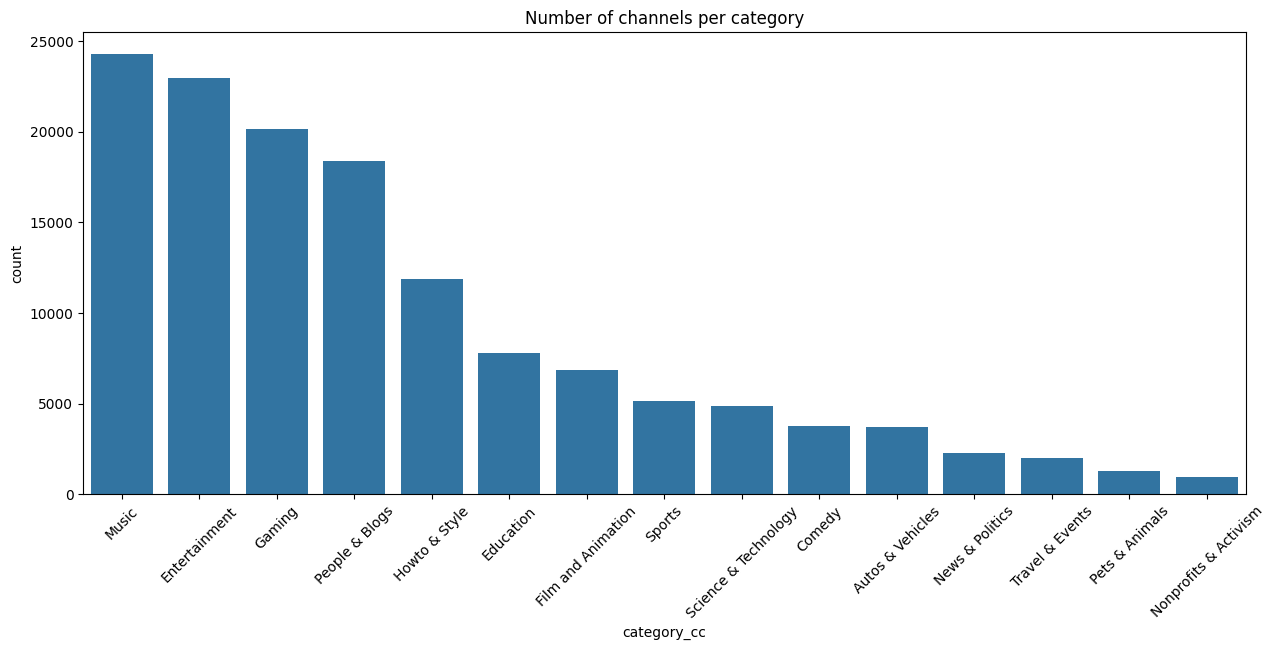

category_cc
Music                    24285
Entertainment            22950
Gaming                   20143
People & Blogs           18413
Howto & Style            11875
Education                 7803
Film and Animation        6875
Sports                    5148
Science & Technology      4864
Comedy                    3767
Autos & Vehicles          3705
News & Politics           2263
Travel & Events           1989
Pets & Animals            1292
Nonprofits & Activism      969
Name: count, dtype: int64

In [19]:
# Plot the number of channels per category
plt.figure(figsize=(15, 6))
sns.countplot(x="category_cc", data=df_ch_f, order=df_ch_f.category_cc.value_counts().index)
plt.xticks(rotation=45)
plt.title("Number of channels per category")
plt.show()
df_ch_f.category_cc.value_counts()

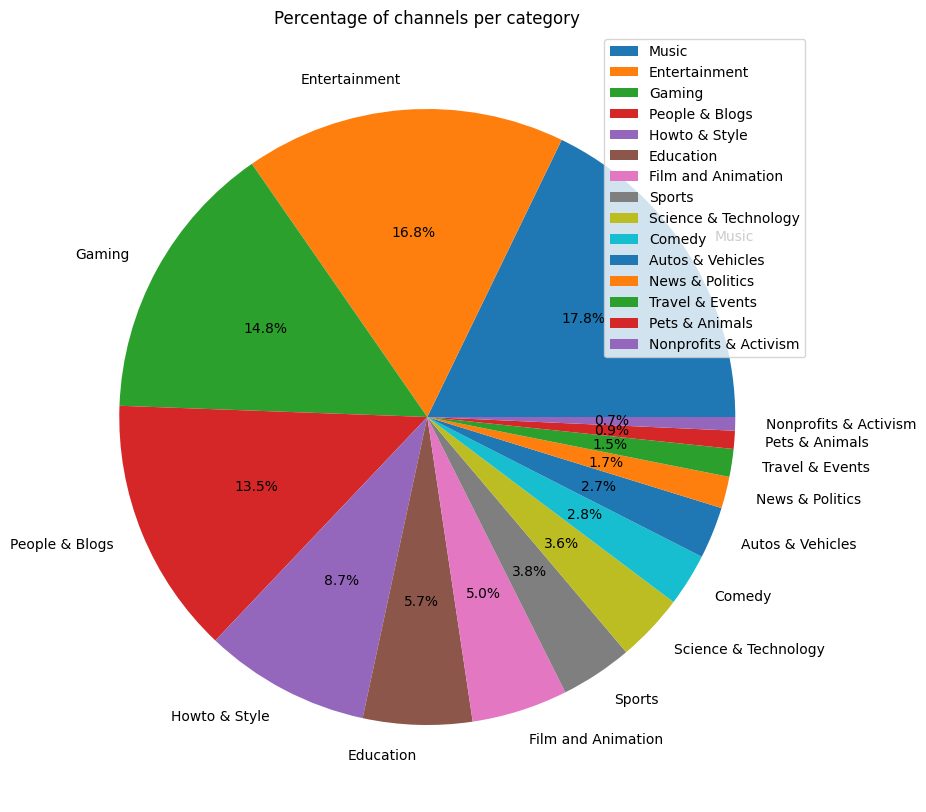

In [20]:
# Plot pie chart percentage of channels per category
plt.figure(figsize=(10, 10))
df_ch_f.category_cc.value_counts().plot.pie(autopct='%1.1f%%')
plt.title("Percentage of channels per category")
plt.ylabel("")
plt.legend()
plt.show()

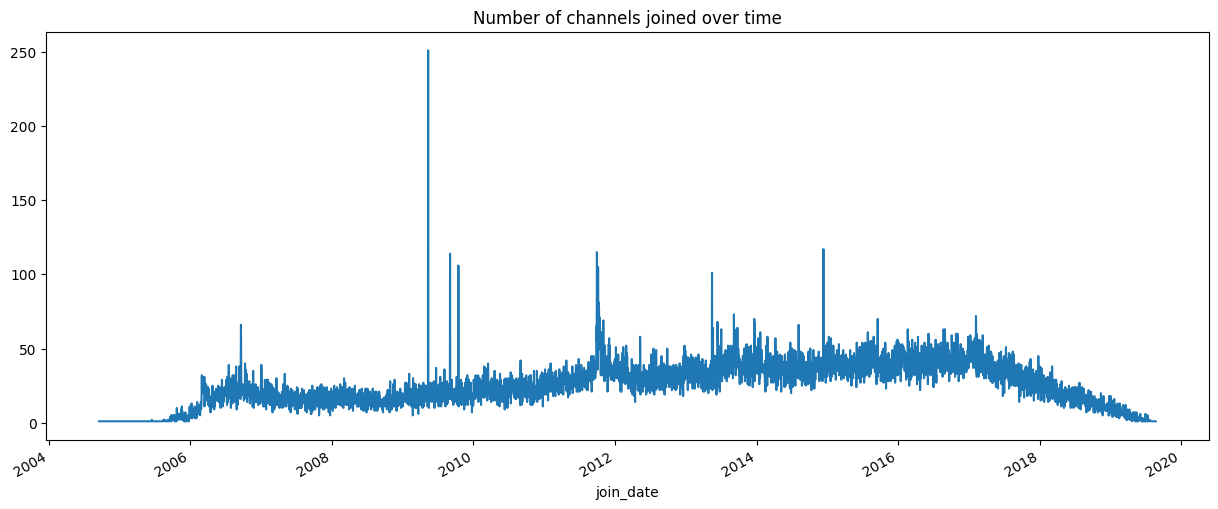

In [21]:
# Number of channels joined over time line plot
plt.figure(figsize=(15, 6))
df_ch_f["join_date"].value_counts().sort_index().plot()
plt.title("Number of channels joined over time")
plt.show()

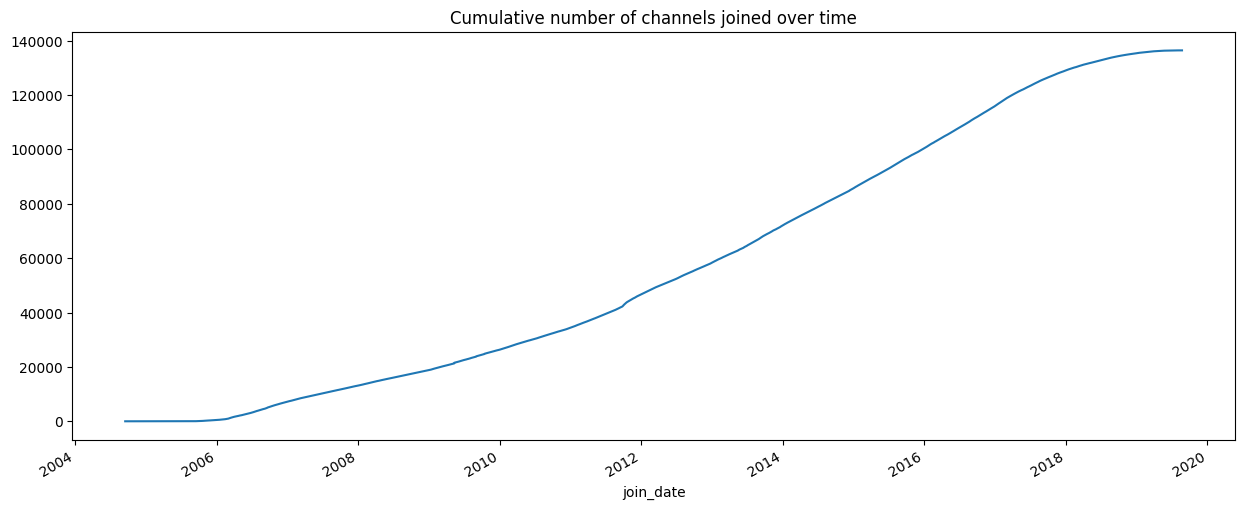

In [22]:
# Culmulative number of channels joined over time
cumulative_counts = df_ch_f["join_date"].value_counts().sort_index().cumsum()

plt.figure(figsize=(15, 6))
cumulative_counts.plot()
plt.title("Cumulative number of channels joined over time")
plt.show()

<Figure size 1500x600 with 0 Axes>

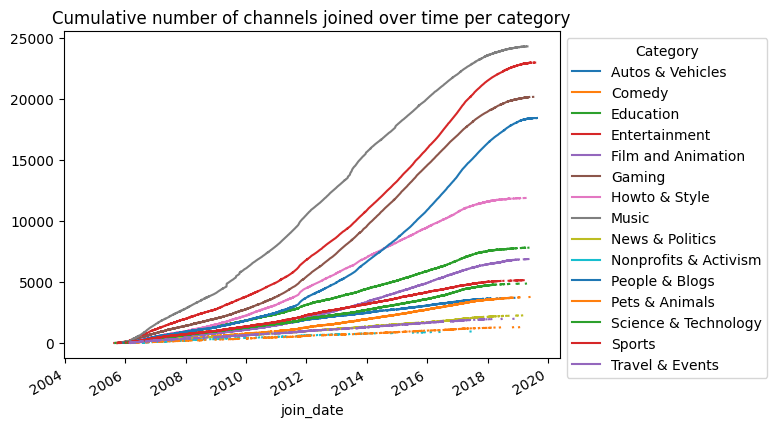

In [23]:
# Culumative number of channels joined over time per category
plt.figure(figsize=(15, 6))
df_ch_f.groupby(["join_date", "category_cc"]).size().unstack().cumsum().plot()
plt.title("Cumulative number of channels joined over time per category")
plt.legend(title="Category", bbox_to_anchor=(1, 1))
plt.show()

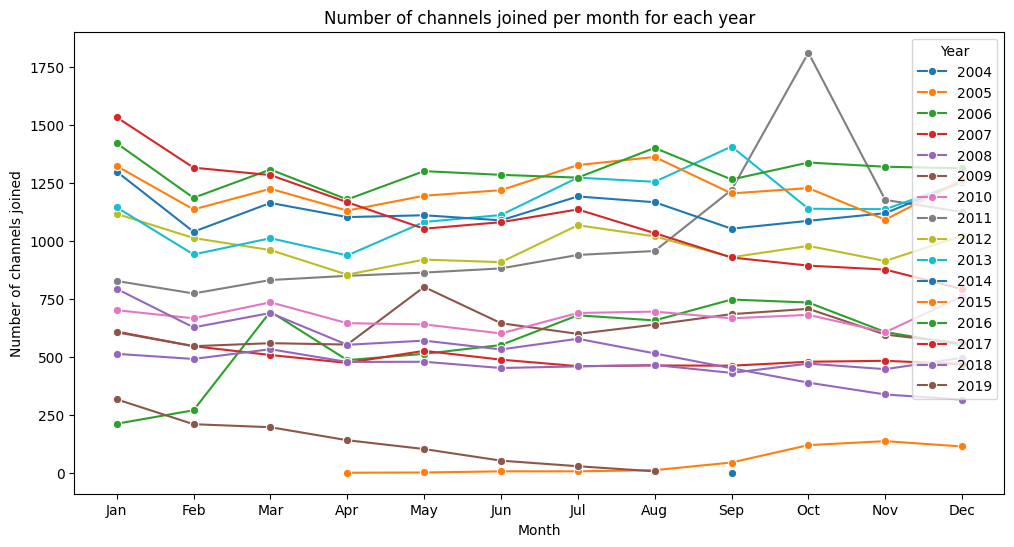

In [24]:
# Number of channels joined per month for each year
df_ch_f["year"] = df_ch_f["join_date"].dt.year.astype(int)
df_ch_f["month"] = df_ch_f["join_date"].dt.month

monthly_counts = df_ch_f.groupby(["year", "month"]).size().reset_index(name="channel_count")

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_counts, x="month", y="channel_count", hue="year", palette="tab10", marker="o")

plt.xlabel("Month")
plt.ylabel("Number of channels joined")
plt.title("Number of channels joined per month for each year")
plt.legend(title="Year", loc="upper right")
plt.xticks(range(1, 13), 
           ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.show()

<Figure size 1500x600 with 0 Axes>

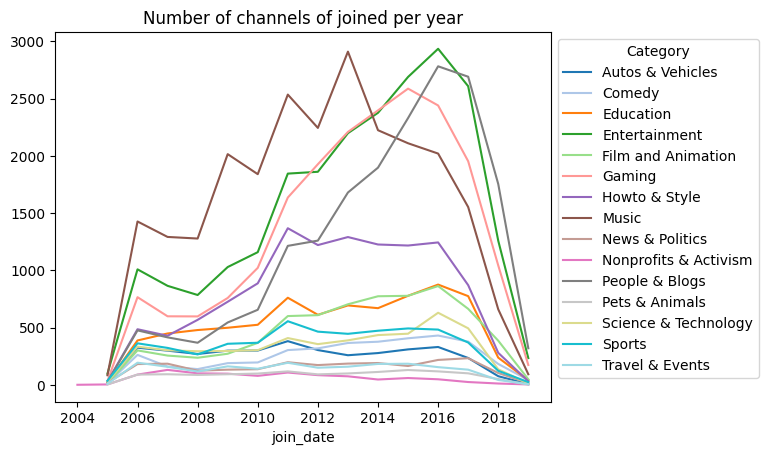

In [25]:
# Number of channels of different categories joined per year
plt.figure(figsize=(15, 6))
df_ch_f.groupby([df_ch_f["join_date"].dt.year, "category_cc"]).size().unstack().plot(colormap="tab20")
plt.title("Number of channels of joined per year")
plt.legend(title="Category", bbox_to_anchor=(1, 1))
plt.show()

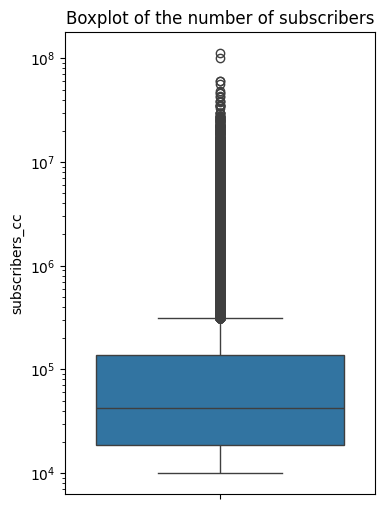

In [26]:
# Boxplot of the number of subscribers
plt.figure(figsize=(4, 6))
sns.boxplot(y="subscribers_cc", data=df_ch_f)
plt.title("Boxplot of the number of subscribers")
plt.yscale("log")
plt.show()


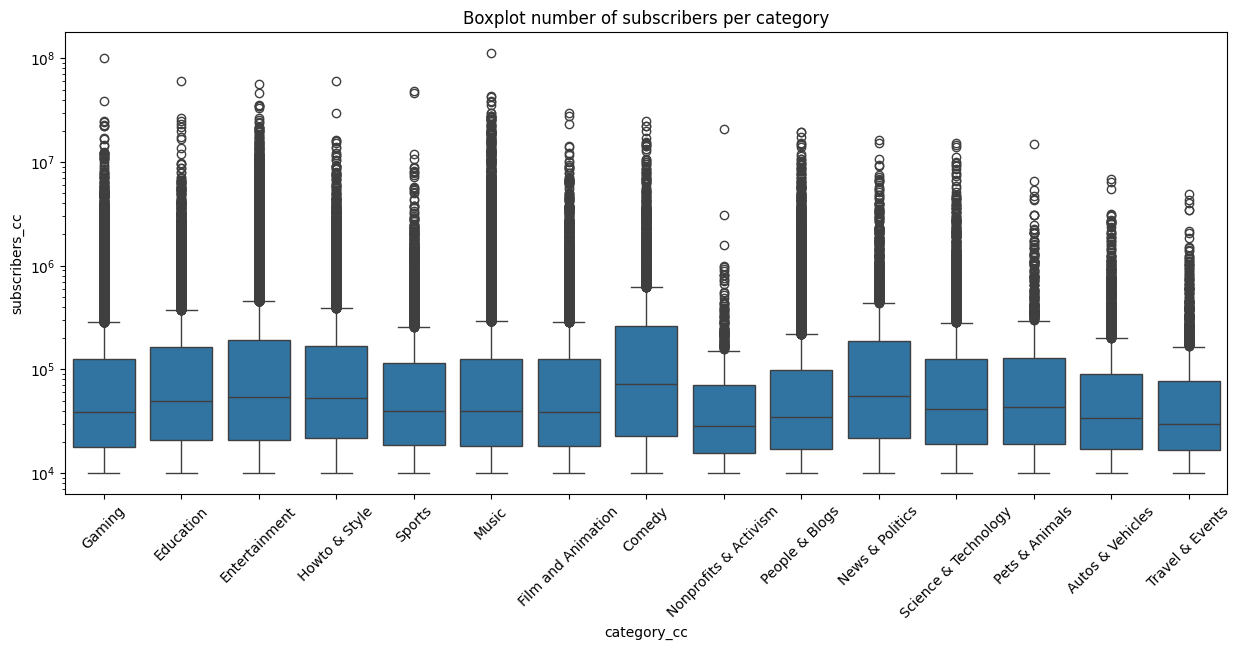

In [27]:
# Boxplot of the number of subscribers per category
plt.figure(figsize=(15, 6))
sns.boxplot(x="category_cc", y="subscribers_cc", data=df_ch_f)
plt.xticks(rotation=45)
plt.title("Boxplot number of subscribers per category")
plt.yscale("log")
plt.show()

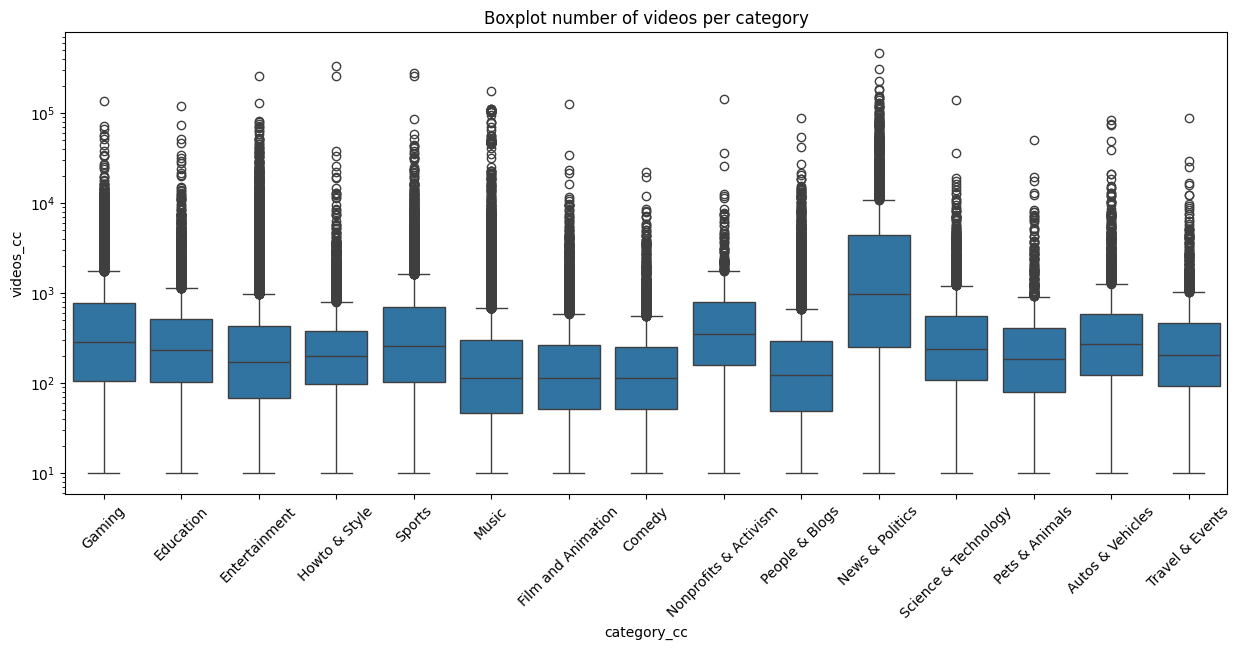

In [28]:
# Boxplot of the number of videos per category
plt.figure(figsize=(15, 6))
sns.boxplot(x="category_cc", y="videos_cc", data=df_ch_f)
plt.xticks(rotation=45)
plt.title("Boxplot number of videos per category")
plt.yscale("log")
plt.show()

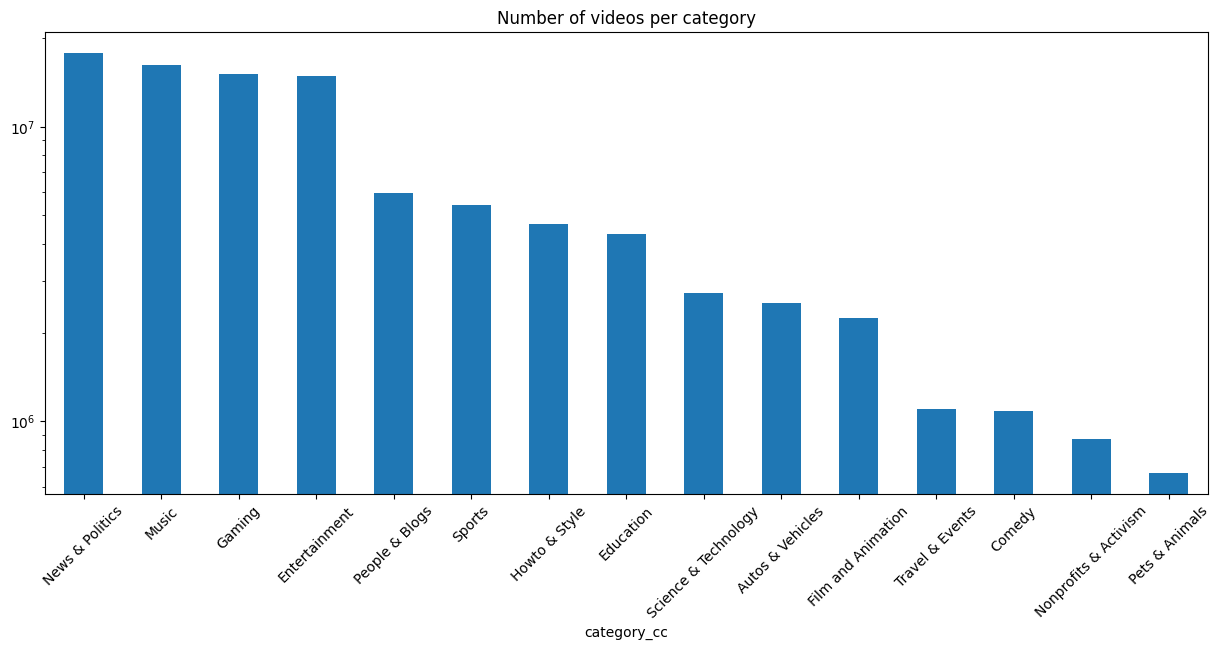

In [29]:
# Total number of videos per category in descending order
plt.figure(figsize=(15, 6))
df_ch_f.groupby("category_cc")["videos_cc"].sum().sort_values(ascending=False).plot(kind="bar")
plt.xticks(rotation=45)
plt.yscale("log")
plt.title("Number of videos per category")
plt.show()

## Timeseries data

In [30]:
df_ts_f.head(5)

channel            category   datetime         views  \
0  UCBJuEqXfXTdcPSbGO9qqn1g  Film and Animation 2017-07-03  2.024946e+05   
1  UCBJuEqXfXTdcPSbGO9qqn1g  Film and Animation 2017-07-10  3.940857e+05   
2  UCBJuEqXfXTdcPSbGO9qqn1g  Film and Animation 2017-07-17  8.353938e+05   
3  UCBJuEqXfXTdcPSbGO9qqn1g  Film and Animation 2017-07-24  1.104577e+06   
4  UCBJuEqXfXTdcPSbGO9qqn1g  Film and Animation 2017-07-31  1.284406e+06   

     delta_views         subs  delta_subs  videos  delta_videos  activity  
0       0.000000   650.222222    0.000000       5             0         3  
1  191591.111111  1046.000000  395.777778       6             1         1  
2  441308.083333  1501.500000  455.500000       6             0         1  
3  269183.250000  1750.000000  248.500000       6             0         0  
4  179828.600000  2008.300000  258.300000       6             0         0

In [31]:
# Examine NaN values
print("Number of NaN values in each column:")
print(df_ts_f.isnull().sum())

Number of NaN values in each column:
channel             0
category        20584
datetime            0
views               0
delta_views         0
subs                0
delta_subs          0
videos              0
delta_videos        0
activity            0
dtype: int64


In [32]:
# Check timeseries period
print("Start date: ", df_ts_f["datetime"].min())
print("End date: ", df_ts_f["datetime"].max())

Start date:  2015-01-05 00:00:00
End date:  2019-09-30 01:00:00


In [33]:
df_ts_f["channel"].nunique()

133516

In [34]:
# Number of missing channels in timeseries dataset
n_missing_channels = df_ch_f["channel"].nunique() - df_ts_f["channel"].nunique()
print("Total number of channels in channel dataset: ", df_ch_f.shape[0])
print(f"Number of missing channels in timeseries dataset: {n_missing_channels} accounted for {n_missing_channels / df_ch_f.shape[0] * 100:.2f}% of the total channels")

n_missing_sports_channels = df_ch_f[df_ch_f["category_cc"] == "Sports"]["channel"].nunique() - df_ts_f[df_ts_f["category"] == "Sports"]["channel"].nunique()
print(f"Number of missing sports channels in timeseries dataset: {n_missing_sports_channels} accounted for {n_missing_sports_channels / df_ch_f[df_ch_f['category_cc'] == 'Sports'].shape[0] * 100:.2f}% of the total sports channels")

Total number of channels in channel dataset:  136469
Number of missing channels in timeseries dataset: 2953 accounted for 2.16% of the total channels
Number of missing sports channels in timeseries dataset: 128 accounted for 2.49% of the total sports channels


In [35]:
# Sort data in increasing order of datetime
df_ts_f = df_ts_f.sort_values("datetime")

In [36]:
# Check if the datetime period between 2 consecutive collected data of each channel is 7 days
df_ts_f["time_diff"] = df_ts_f.groupby("channel")["datetime"].diff()
df_ts_f["time_diff"].value_counts()

time_diff
7 days 00:00:00    18068328
7 days 01:00:00      351204
6 days 23:00:00      319451
Name: count, dtype: int64

## Comment data

In [39]:
# Overview
df_co_f.head()

author     video_id  likes  replies
0       1  Gkb1QMHrGvA      2        0
1       1  CNtp0xqoods      0        0
2       1  249EEzQmVmQ      1        0
3       1  _U443T2K_Bs      0        0
4       1  rJbjhm0weYc      0        0

In [40]:
print("The top 10 most active authors:")
df_co_f.groupby("author").size().sort_values(ascending=False).head(10)

The top 10 most active authors:


author
1032141    49125
58087      37389
193683     36313
3937636    28314
2318784    28090
950989     26389
3455878    24235
5343860    24217
776469     23716
3891056    23353
dtype: int64

In [41]:
print("The top 10 authors with the most comments:")
df_co_f_sum_by_author = df_co_f.groupby("author").sum()
df_co_f_sum_by_author["likes"].sort_values(ascending=False).head(10)

The top 10 authors with the most comments:


author
3181197    1442113
3116283     848281
3683601     643523
2011638     625528
3937636     533584
2037228     421242
5743067     414229
1897985     414052
1913331     401862
3643831     337988
Name: likes, dtype: int64

In [42]:
print("The top 10 authors with the most replies:")
df_co_f_sum_by_author["replies"].sort_values(ascending=False).head(10)

The top 10 authors with the most replies:


author
2011638    104260
129788      84167
3937636     82116
245876      42082
6664124     39334
155881      35131
3643831     34774
3181197     33842
3533947     32743
5343860     29840
Name: replies, dtype: int64

Correlation coefficient: 0.65


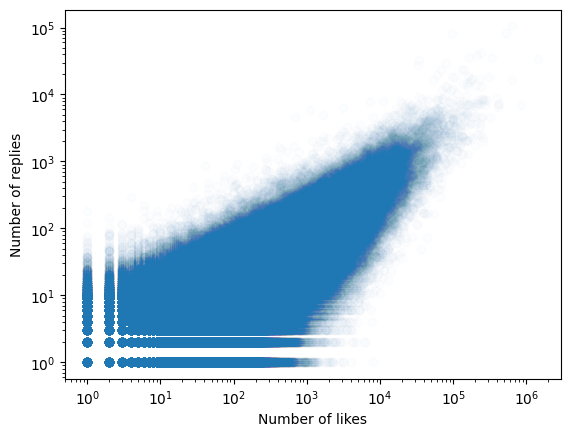

In [43]:
# Correlation between the number of likes and the number of replies
plt.plot(
    df_co_f_sum_by_author["likes"], 
    df_co_f_sum_by_author["replies"], 
    "o",
    alpha=0.01, 
)
plt.xscale("log")
plt.yscale("log")

plt.xlabel("Number of likes")
plt.ylabel("Number of replies")

# calculate the correlation coefficient
print(f"Correlation coefficient: {df_co_f_sum_by_author['likes'].corr(df_co_f_sum_by_author['replies']):.2f}")

# Part 1: General sports-related analysis

### Sports channels

In [44]:
df_ch_sports = df_ch_f[df_ch_f["category_cc"] == "Sports"]

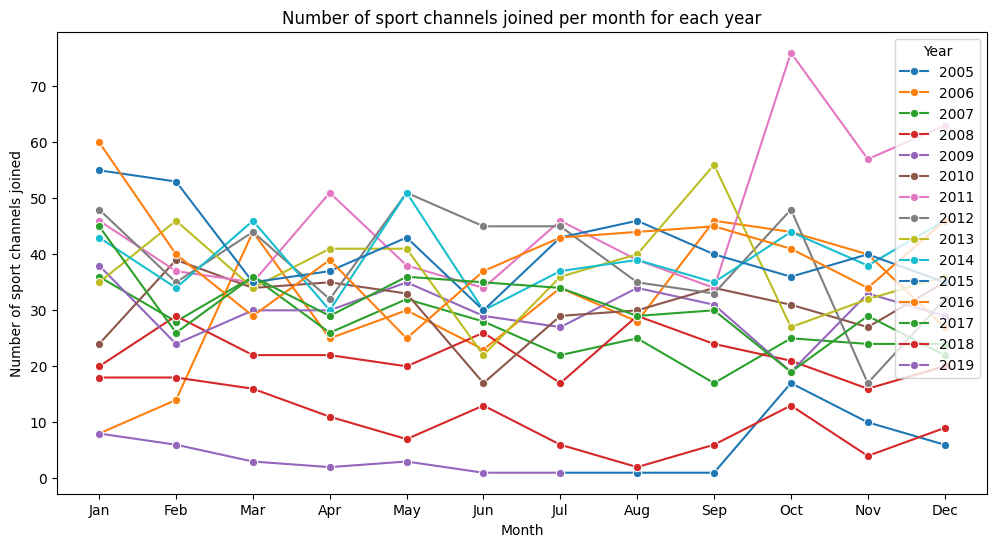

In [45]:
# Number of channels joined per month for each year
df_ch_sports_copy = df_ch_sports.copy()
df_ch_sports_copy["join_year"] = df_ch_sports_copy["join_date"].dt.year.astype(int)
df_ch_sports_copy["join_month"] = df_ch_sports_copy["join_date"].dt.month
monthly_counts = df_ch_sports_copy.groupby(["join_year", "join_month"]).size().reset_index(name="channel_count")

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_counts, x="join_month", y="channel_count", hue="join_year", palette="tab10", marker="o")

plt.xlabel("Month")
plt.ylabel("Number of sport channels joined")
plt.title("Number of sport channels joined per month for each year")
plt.legend(title="Year", loc="upper right")
plt.xticks(range(1, 13), 
           ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.show()

In [46]:
# Merge sports channels with timeseries dataset
df_ch_ts_sports = pd.merge(df_ts_f, df_ch_sports, on="channel", how="inner")

In [47]:
df_ch_ts_sports

channel category            datetime         views  \
0       UCXK9mZC6PaGJ9GYsCVEBWAg   Sports 2015-06-01 00:00:00  2.152142e+06   
1       UCXK9mZC6PaGJ9GYsCVEBWAg   Sports 2015-06-08 00:00:00  2.170332e+06   
2       UCXK9mZC6PaGJ9GYsCVEBWAg   Sports 2015-06-15 00:00:00  2.188061e+06   
3       UCXK9mZC6PaGJ9GYsCVEBWAg   Sports 2015-06-22 00:00:00  2.204538e+06   
4       UCXK9mZC6PaGJ9GYsCVEBWAg   Sports 2015-06-29 00:00:00  2.219691e+06   
...                          ...      ...                 ...           ...   
762258  UCzZ8v5JF3IyxLWOCGKpcP0g   Sports 2019-09-30 01:00:00  4.198264e+06   
762259  UC1QbijZneeECtQp-Pn0OORA   Sports 2019-09-30 01:00:00  1.798509e+07   
762260  UCDzgEpfq5UCYJOaJYXWHbbQ   Sports 2019-09-30 01:00:00  3.287447e+06   
762261  UCj0Vi2KOhULmQ0YrcL17GKw   Sports 2019-09-30 01:00:00  2.609052e+06   
762262  UCNl-VAIGiBTgbb-PWY4MBDA   Sports 2019-09-30 01:00:00  1.135093e+08   

          delta_views           subs   delta_subs  videos  delta_videos  \
0        14170.500000    9892.000000     0.000000      26             0   
1        18190.375000    9951.875000    59.875000      26             0   
2        17729.013889   10008.666667    56.791667      26             0   
3        16476.861111   10065.750000    57.083333      26             0   
4        15153.500000   10115.250000    49.500000      26             0   
...               ...            ...          ...     ...           ...   
762258  109228.700893   21600.000000   221.875000     175             0   
762259  279903.774405  186589.285714  2697.577381     501            26   
762260   23978.798280   18100.000000    98.611111     113             0   
762261   50161.004762   21116.071429   313.988095      52            11   
762262  767197.638393  379434.523810  2413.690476    4820            20   

        activity time_diff category_cc  join_date              name_cc  \
0              0       NaT      Sports 2011-07-25         bellicon USA   
1              0    7 days      Sports 2011-07-25         bellicon USA   
2              0    7 days      Sports 2011-07-25         bellicon USA   
3              0    7 days      Sports 2011-07-25         bellicon USA   
4              0    7 days      Sports 2011-07-25         bellicon USA   
...          ...       ...         ...        ...                  ...   
762258        14    7 days      Sports 2018-01-14            NattoSumo   
762259        40    7 days      Sports 2018-01-28        Jilani Sports   
762260         0    7 days      Sports 2016-01-03      My Classic Boat   
762261        11    7 days      Sports 2018-02-19  On Ice Perspectives   
762262        74    7 days      Sports 2015-10-31          Mixer World   

        subscribers_cc  videos_cc  subscriber_rank_sb  weights  year  month  
0                18500        102            602166.0  11.2270  2011      7  
1                18500        102            602166.0  11.2270  2011      7  
2                18500        102            602166.0  11.2270  2011      7  
3                18500        102            602166.0  11.2270  2011      7  
4                18500        102            602166.0  11.2270  2011      7  
...                ...        ...                 ...      ...   ...    ...  
762258           21500        203            422188.0   7.4080  2018      1  
762259          182000        474             88248.0   4.1880  2018      1  
762260           17890        113            584949.0   9.9210  2016      1  
762261           20700         40            378274.0   8.3445  2018      2  
762262          373764       4751             45179.0   3.3130  2015     10  

[762263 rows x 20 columns]

In [48]:
def plot_sum_delta_amount_overtime(df, delta_cols: list[str]):
    # Create a new column that combines year and month
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['year_month'] = df['year'].astype(
        str) + '-' + df['month'].astype(str).str.zfill(2)

    # Group by the new 'year_month' column and sum the "delta" counts
    year_month_view_count = df.groupby('year_month')[delta_cols].sum().reset_index()
    
    # print(year_month_view_count.head())

    # Plot the data
    plt.figure(figsize=(40, 12))
    for delta_col in delta_cols:
        plt.plot(year_month_view_count['year_month'],
                 year_month_view_count[delta_col], marker='o', label=delta_col)
    plt.title(f'Sum {delta_cols} over time')
    plt.xlabel('Time')
    plt.ylabel('')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.show()

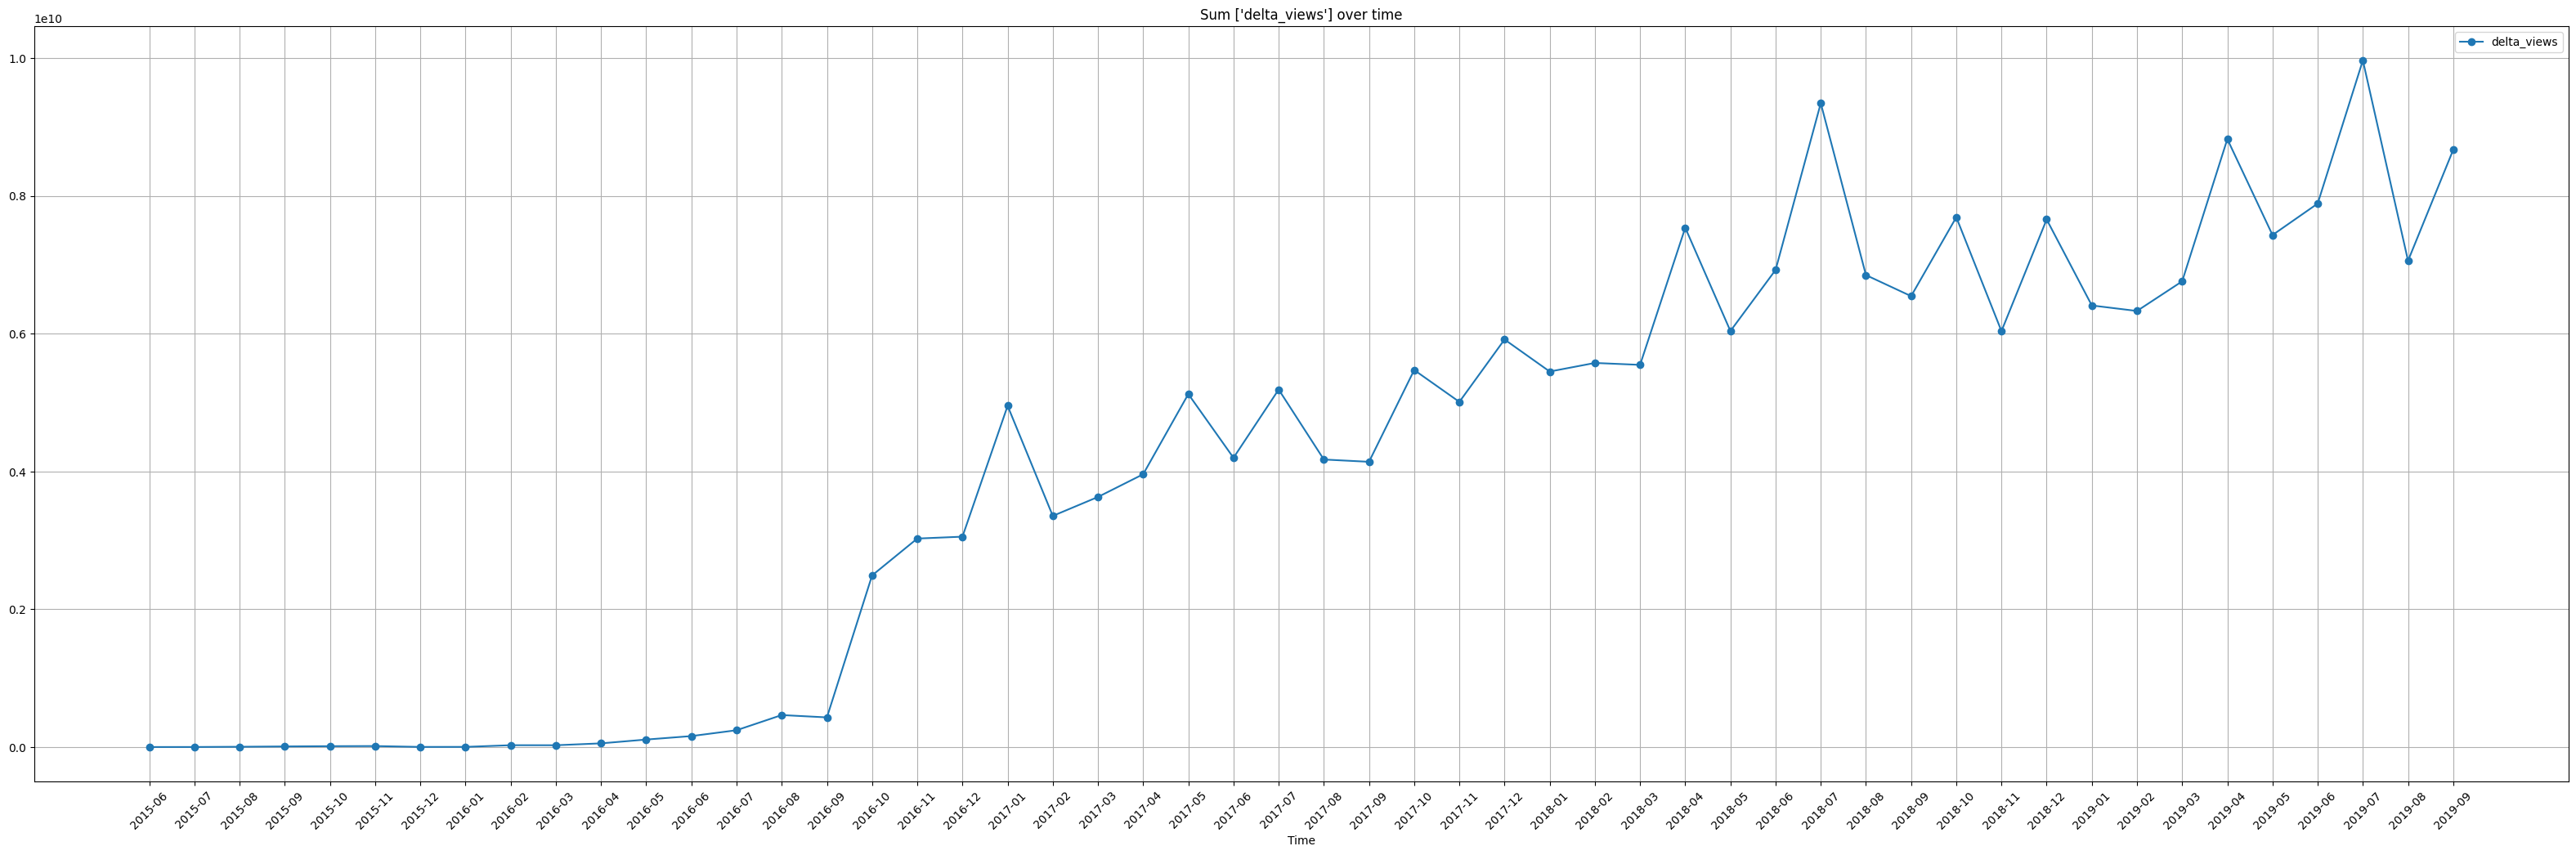

In [49]:
plot_sum_delta_amount_overtime(df_ch_ts_sports, ["delta_views"])

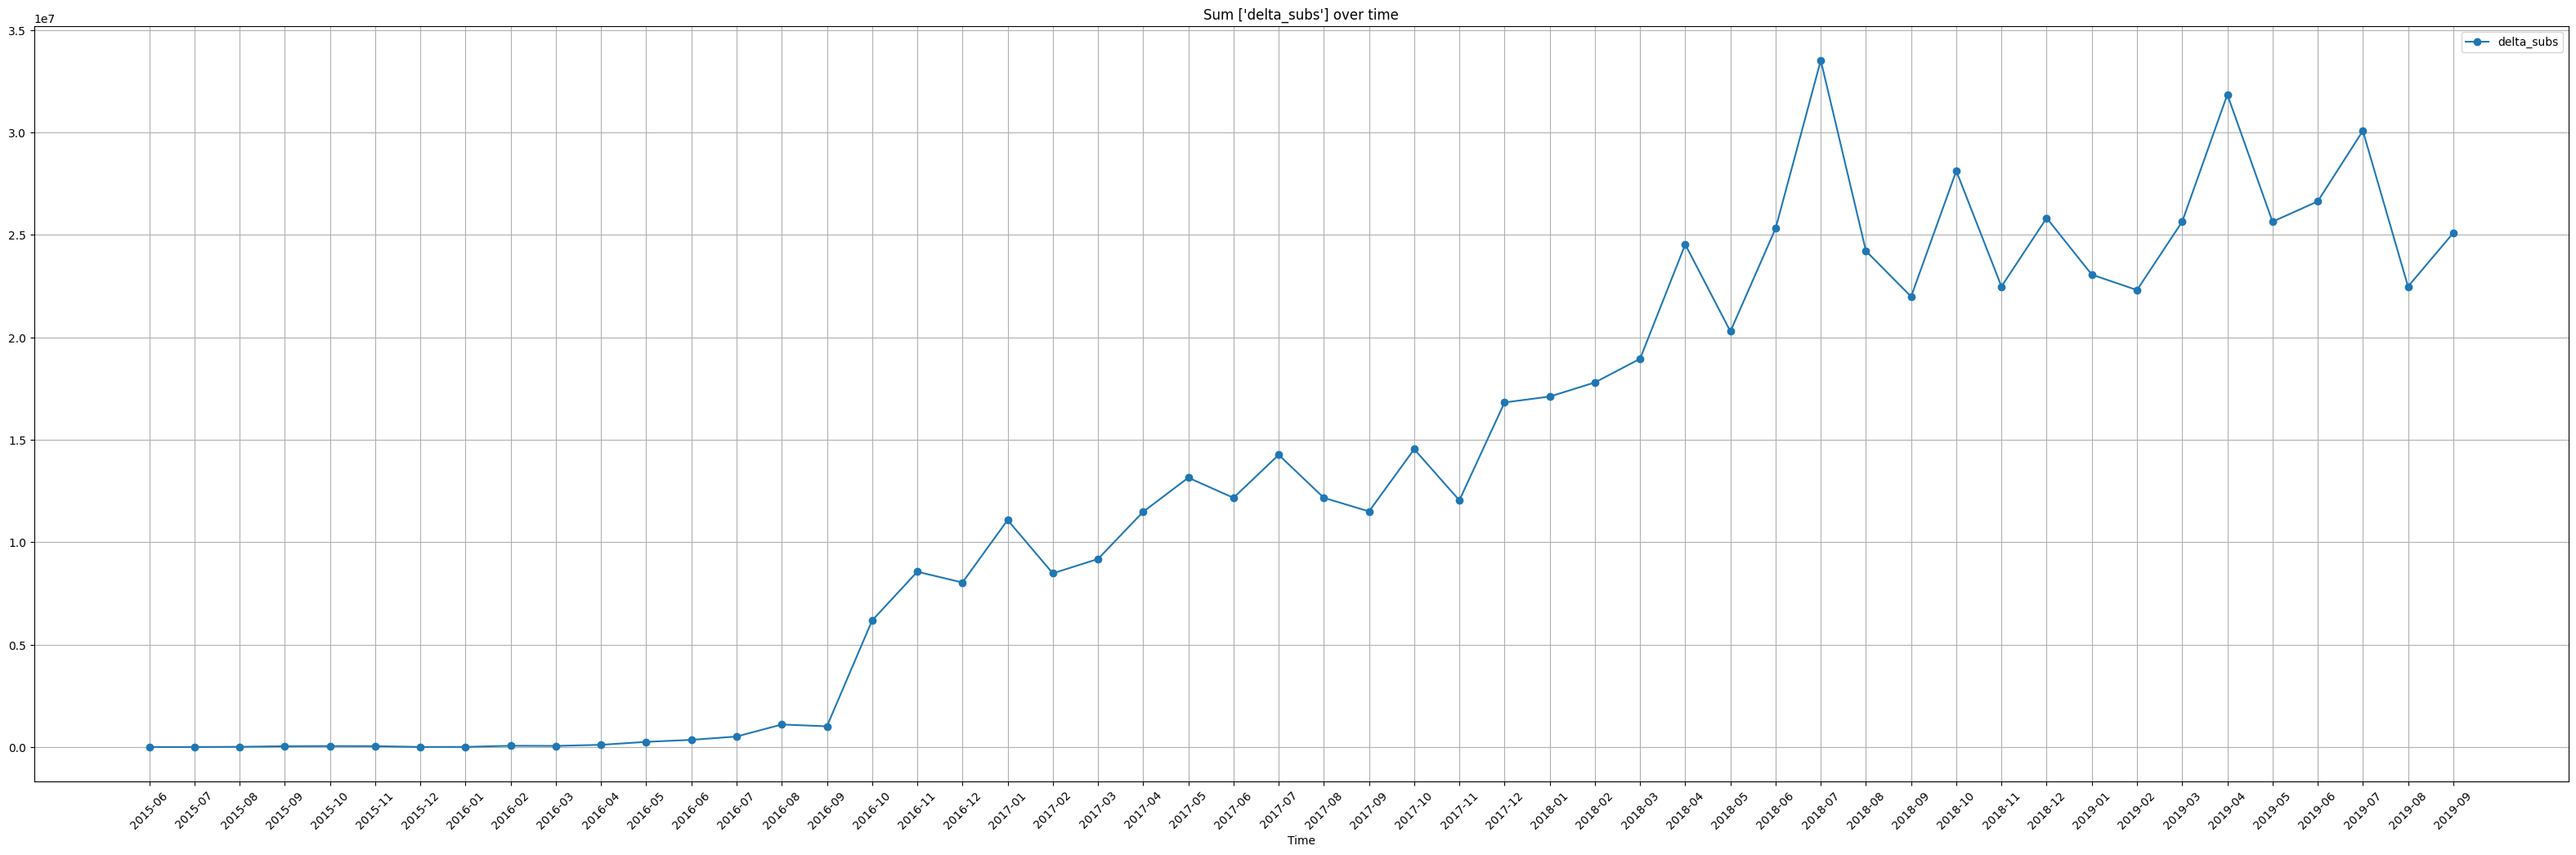

In [50]:
plot_sum_delta_amount_overtime(df_ch_ts_sports, ["delta_subs"])

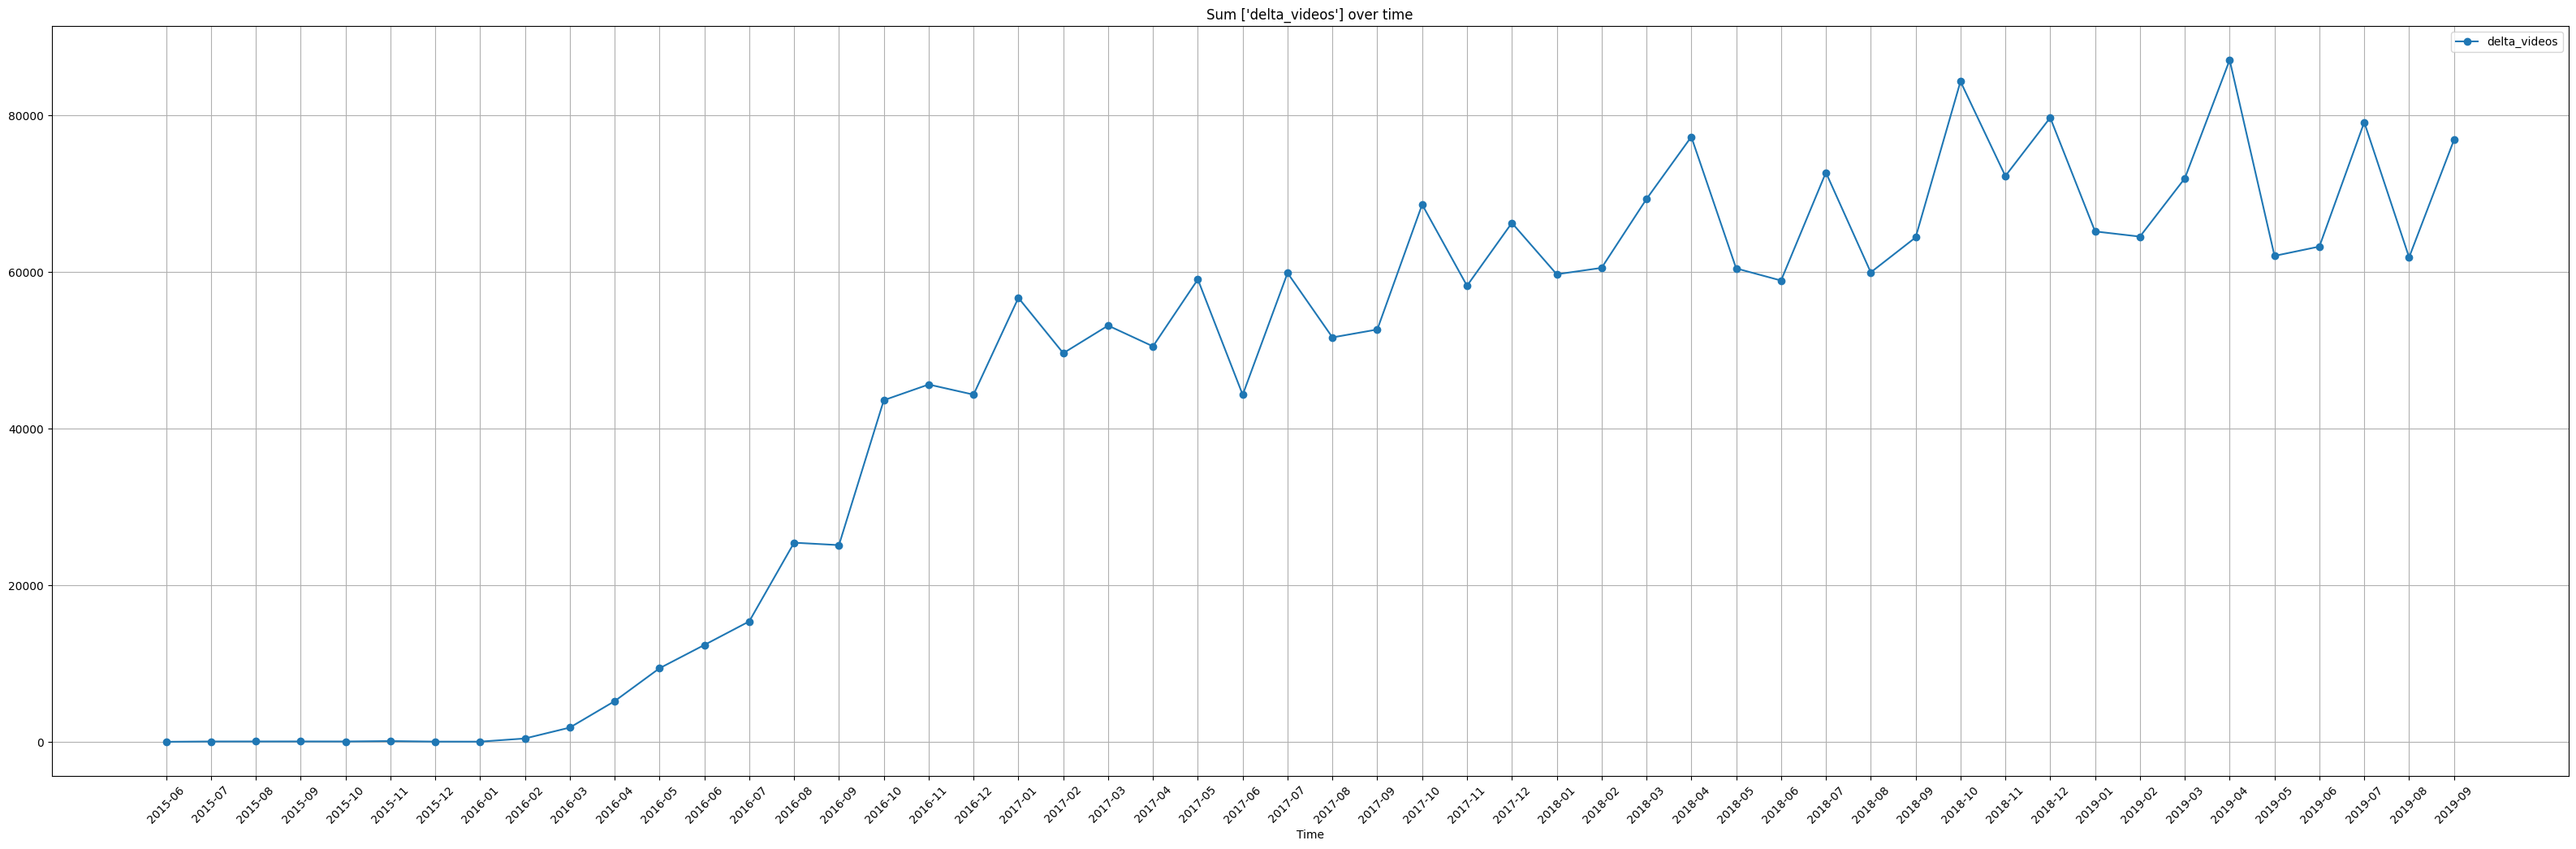

In [51]:
plot_sum_delta_amount_overtime(df_ch_ts_sports, ["delta_videos"])

In [52]:
# Plot X by month for each year
def plot_x_by_month_for_each_year(df, x_col: str, years=None):
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    if years is not None:
        df = df[df['year'].isin(years)]
        
    data = df.groupby(['year', 'month'])[x_col].sum().reset_index()
    
    pivot_data = data.pivot(index='month', columns='year', values=x_col)
    
    pivot_data.plot(kind='line', figsize=(15, 8))
    plt.title(f'{x_col} by month for each year')
    plt.xlabel('Month')
    plt.ylabel(x_col)
    plt.xticks(range(1, 13), 
               ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
    plt.legend(title='Year')
    plt.show()
        

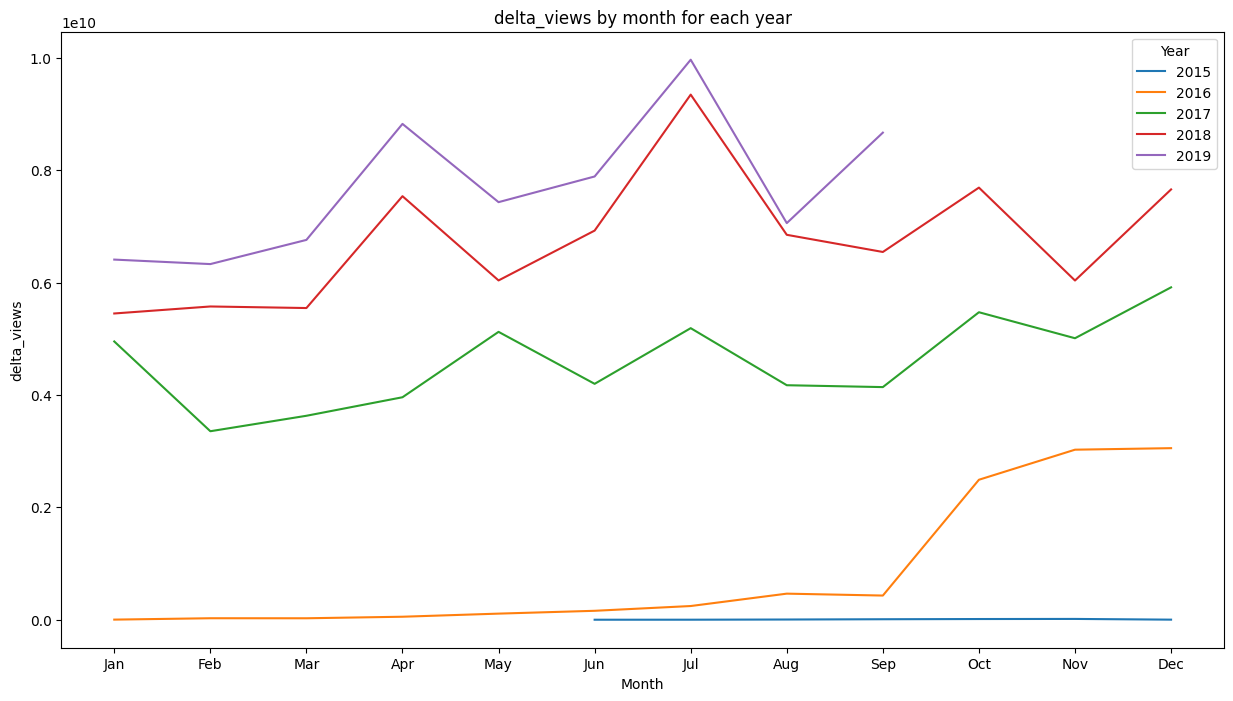

In [53]:
plot_x_by_month_for_each_year(df_ch_ts_sports, 'delta_views')

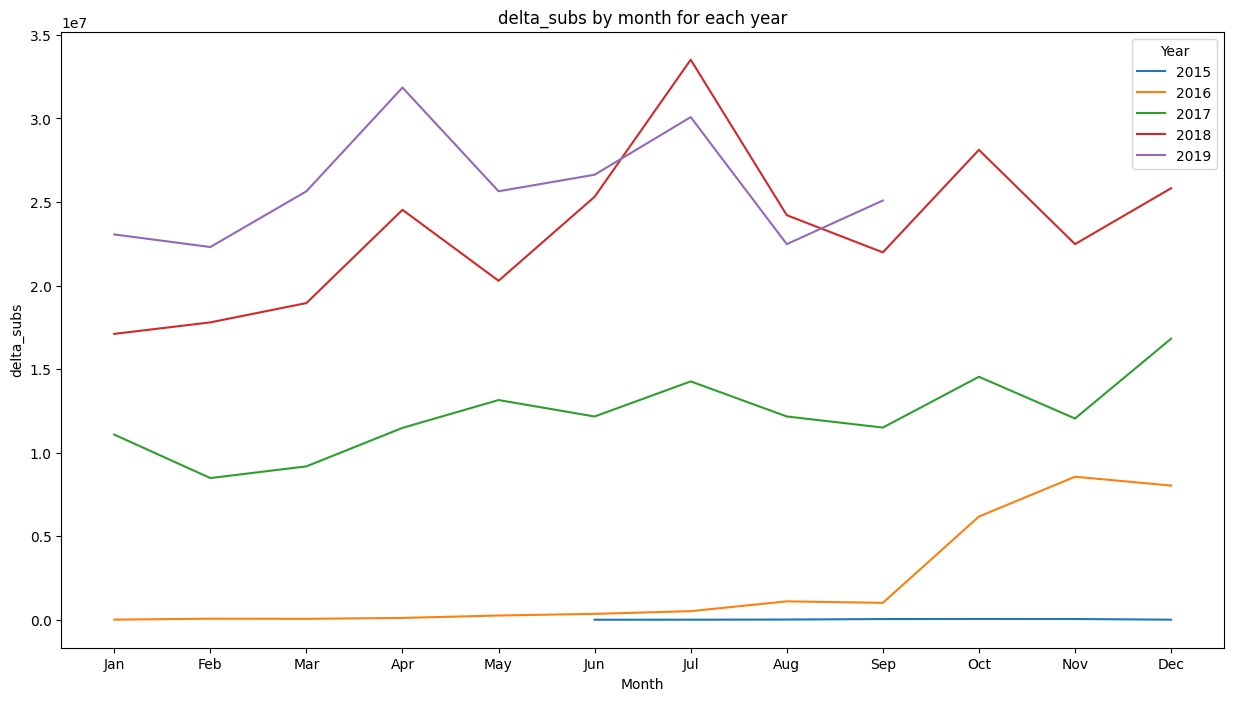

In [54]:
plot_x_by_month_for_each_year(df_ch_ts_sports, 'delta_subs')

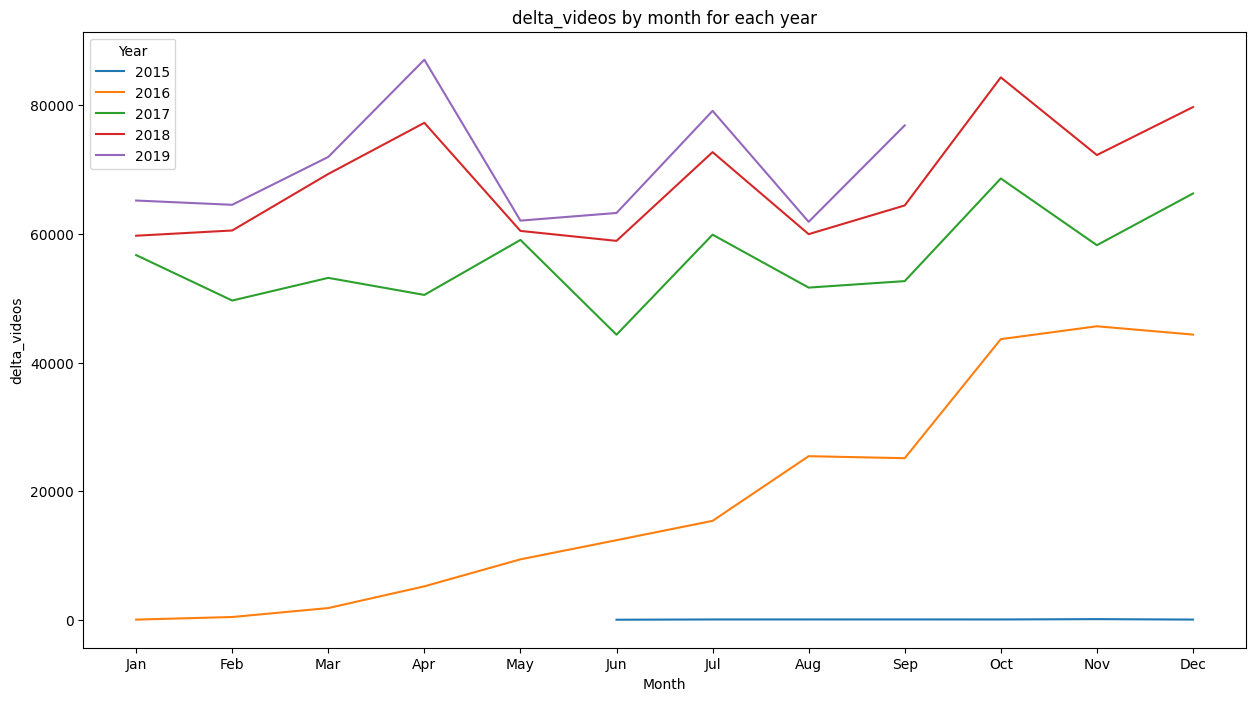

In [55]:
plot_x_by_month_for_each_year(df_ch_ts_sports, 'delta_videos')

### Sports videos

In [9]:
# Note: this dataset is created using script in src/scripts/sport_videos.py

# Load sports category videos dataset (with descriptions and tags)
pq_sports = pq.ParquetFile(os.path.join(DATA_PATH, "yt_metadata_en_sport.parquet"))
df_vd_sports = pq_sports.read().to_pandas()

# Change upload_date to datetime
df_vd_sports["upload_date"] = pd.to_datetime(df_vd_sports["upload_date"], format="%Y-%m-%d %H:%M:%S")

In [57]:
df_vd_sports.head(5)

categories                channel_id                  crawl_date  \
index                                                                    
1292      Sports  UCzWn_gTaXyH5Idyo8Raf7_A  2019-11-03 16:39:57.427254   
1293      Sports  UCzWn_gTaXyH5Idyo8Raf7_A  2019-11-03 16:39:58.108323   
1294      Sports  UCzWn_gTaXyH5Idyo8Raf7_A  2019-11-03 16:39:58.773085   
1295      Sports  UCzWn_gTaXyH5Idyo8Raf7_A  2019-11-03 16:39:59.465346   
1296      Sports  UCzWn_gTaXyH5Idyo8Raf7_A  2019-11-03 16:40:00.188768   

                                             description  dislike_count  \
index                                                                     
1292   Can I catch 100 lbs of catfish LIVE. Me and Ja...           35.0   
1293                                                               15.0   
1294   Are you ready to enter the high fashion world ...           78.0   
1295   Saltwater fishing out of Newquay Cornwall UK. ...           70.0   
1296   My family spent 3 weeks touring England and fi...           73.0   

        display_id  duration  like_count  \
index                                      
1292   JOeSxtcNdHQ      8620      1673.0   
1293   EPMLTw2zINw       355      1297.0   
1294   Y1_pK68iSYQ       603      3305.0   
1295   jF8TSo3ZfTc      1426      1889.0   
1296   Gp00dNaVouo       990      2699.0   

                                                    tags  \
index                                                      
1292   catfishing,fishing,fishing challenge,catfish,c...   
1293                                                       
1294   Catfishing,how to catch catfish,fishing,classy...   
1295   Fishing,Fishing uk,Angling,Sea angling,sea ang...   
1296   Fishing,catfish,wels catfish,how to catch catf...   

                                                   title upload_date  \
index                                                                  
1292                   Catching 100 lbs of Catfish 🔴Live  2019-10-01   
1293                                             big cat  2019-10-01   
1294   Classy Catfishing - How to Catch Catfish the P...  2019-09-28   
1295   2 Day Saltwater Fishing Catch & Cook - UK Sea ...  2019-09-21   
1296   How to Catch Wels Catfish - Fishing for Catfis...  2019-09-14   

       view_count  
index              
1292      48737.0  
1293      19999.0  
1294      58518.0  
1295      71998.0  
1296     101924.0

In [18]:
def get_all_tags(df: pd.DataFrame) -> list[str]:
    df['tags'] = df['tags'].str.lower()
    df['tags'] = df['tags'].str.replace("world cup", "world_cup")
    df['tags'] = df['tags'].str.replace("table tennis", "table_tennis")
    df['tags'] = df['tags'].str.replace("ping pong", "table_tennis")
    
    all_tags = []
    for tags in df['tags']:
        tag_list = tags.split(",") # "a, b c, d" -> ["a", "b c", "d"]
        for sentence in tag_list:
            all_tags.extend(sentence.split()) # "b c" -> ["b", "c"]
    
    return all_tags

In [19]:
all_tags_sport = get_all_tags(df_vd_sports)

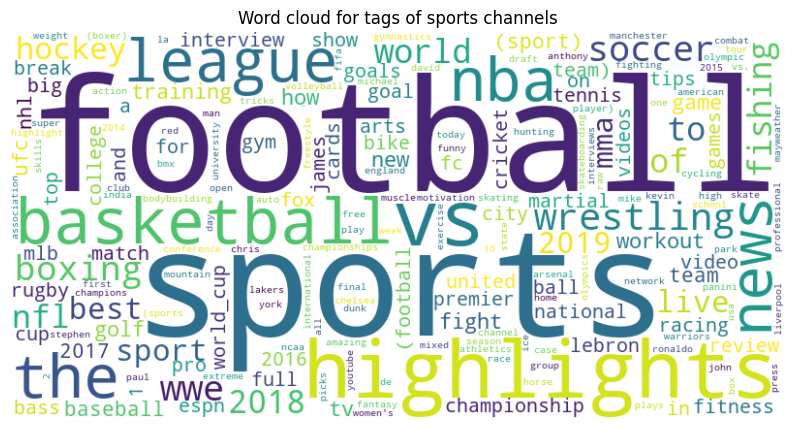

In [61]:
# Plot word cloud for tags of sports channels
plot_wordcloud(all_tags_sport, "Word cloud for tags of sports channels")

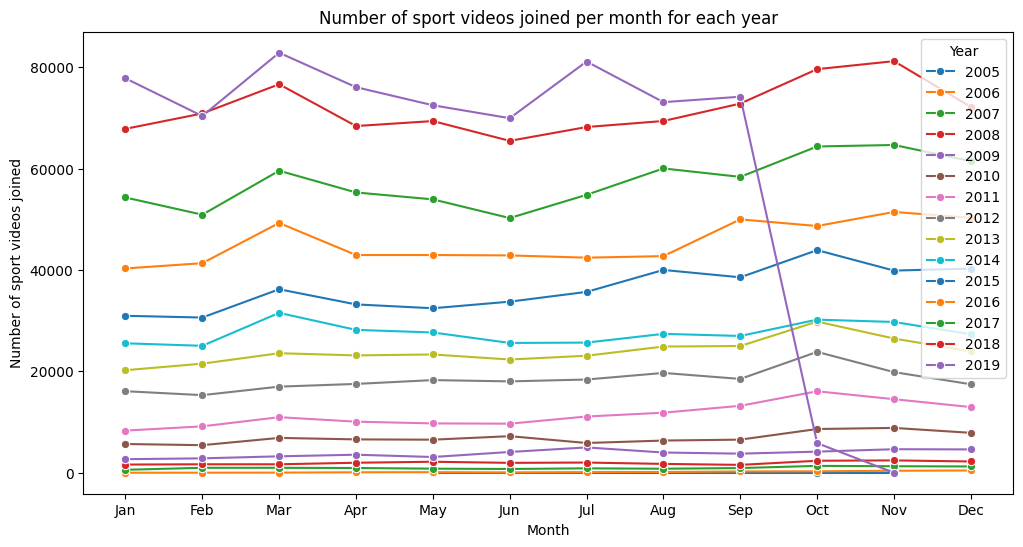

In [62]:
# Number of of sports videos uploaded per month for each year
df_vd_sports_copy = df_vd_sports.copy()
df_vd_sports_copy["year"] = df_vd_sports_copy["upload_date"].dt.year.astype(int)
df_vd_sports_copy["month"] = df_vd_sports_copy["upload_date"].dt.month

monthly_counts = df_vd_sports_copy.groupby(["year", "month"]).size().reset_index(name="video_count")

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_counts, x="month", y="video_count", hue="year", palette="tab10", marker="o")

plt.xlabel("Month")
plt.ylabel("Number of sport videos joined")
plt.title("Number of sport videos joined per month for each year")
plt.legend(title="Year", loc="upper right")
plt.xticks(range(1, 13), 
           ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.show()

# Part 2: Major sports events analysis

We consider 3 major sports events namely Olympics, Worldcup, and NBA. For each event, we get the relevant videos by searching for our defined keywords in their descriptions, tags and/or titles.

For now, we just filter videos from sports category, but we may extend the scope to include videos from all categories if needed later. 

Additionally, we plan to use pretrained classification models to identify videos related to sports events, as we hope this approach will be more accurate than manual filtering based on predefined keywords.

In [10]:
olympics_keywords = [
    'olympic', 'olympics', 'olympiad', 'beijing 2008', 'london 2012',
    'rio 2016', 'pyeongchang 2018', 'sochi 2014', 'tokyo 2020', 'olympic games',
    'winter olympics', 'summer olympics'
]

df_olympics = get_related_videos_with_keywords(df_vd_sports, olympics_keywords)

In [11]:
world_cup_keywords = [
   'world cup', 'worldcup', '2018 russia', '2014 brazil', '2010 south africa',
]

df_world_cup = get_related_videos_with_keywords(df_vd_sports, world_cup_keywords)

In [12]:
nba_keywords = [
    'nba', 'national basketball association'
]

df_nba = get_related_videos_with_keywords(df_vd_sports, nba_keywords)

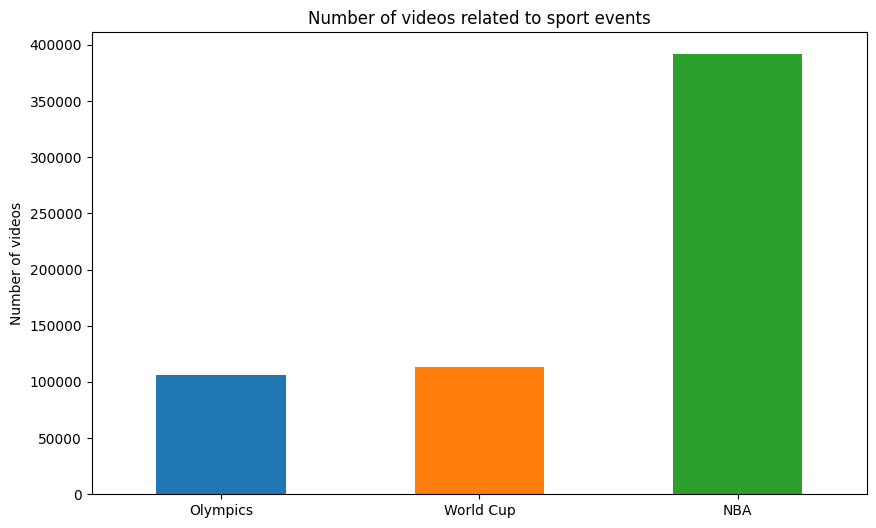

In [13]:
# Number of videos related to each sport event
plt.figure(figsize=(10, 6))
colors = sns.color_palette("tab10")
event_counts = pd.Series({
    "Olympics": df_olympics.shape[0],
    "World Cup": df_world_cup.shape[0],
    "NBA": df_nba.shape[0]
})
event_counts.plot(kind="bar", color=colors)
plt.title("Number of videos related to sport events")
plt.ylabel("Number of videos")
plt.xticks(rotation=0)
plt.show()

## Engagement metrics

In [67]:
df_vd_non_events = df_vd_sports[
  (~df_vd_sports["display_id"].isin(df_olympics["display_id"]))
  & (~df_vd_sports["display_id"].isin(df_world_cup["display_id"])) 
  & (~df_vd_sports["display_id"].isin(df_nba["display_id"]))
]

In [68]:
len(df_vd_non_events)

3768057

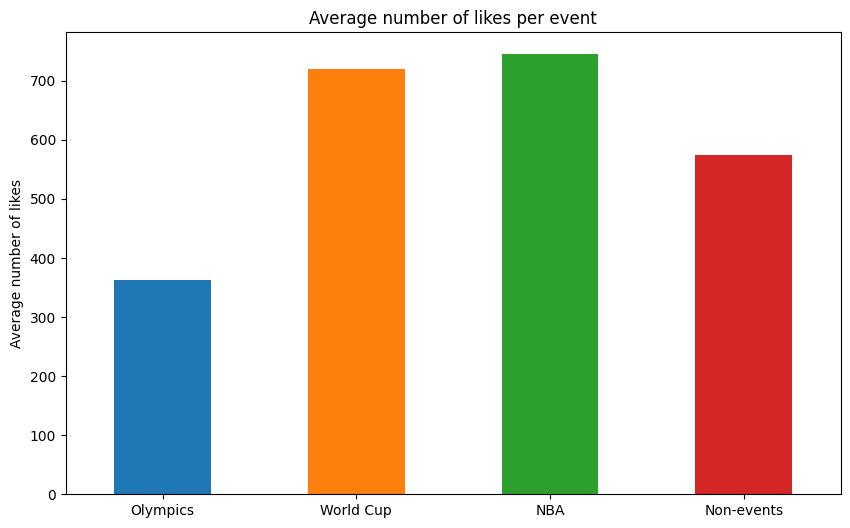

In [69]:
# Average number of likes per event
plt.figure(figsize=(10, 6))
colors = sns.color_palette("tab10")
event_likes = pd.Series({
    "Olympics": df_olympics["like_count"].mean(),
    "World Cup": df_world_cup["like_count"].mean(),
    "NBA": df_nba["like_count"].mean(),
    "Non-events": df_vd_non_events["like_count"].mean()
})
event_likes.plot(kind="bar", color=colors)
plt.title("Average number of likes per event")
plt.ylabel("Average number of likes")
plt.xticks(rotation=0)
plt.show()

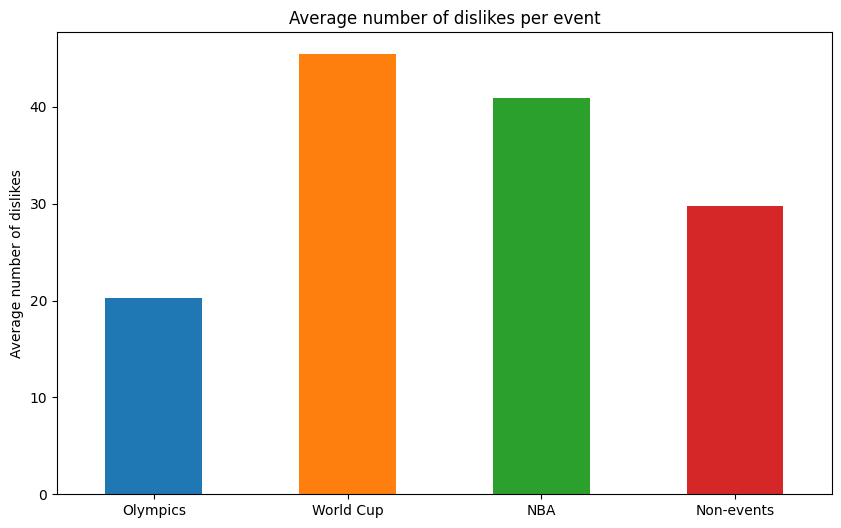

In [70]:
# Average number of dislikes per event
plt.figure(figsize=(10, 6))
colors = sns.color_palette("tab10")
event_dislikes = pd.Series({
    "Olympics": df_olympics["dislike_count"].mean(),
    "World Cup": df_world_cup["dislike_count"].mean(),
    "NBA": df_nba["dislike_count"].mean(),
    "Non-events": df_vd_non_events["dislike_count"].mean()
})
event_dislikes.plot(kind="bar", color=colors)
plt.title("Average number of dislikes per event")
plt.ylabel("Average number of dislikes")
plt.xticks(rotation=0)
plt.show()


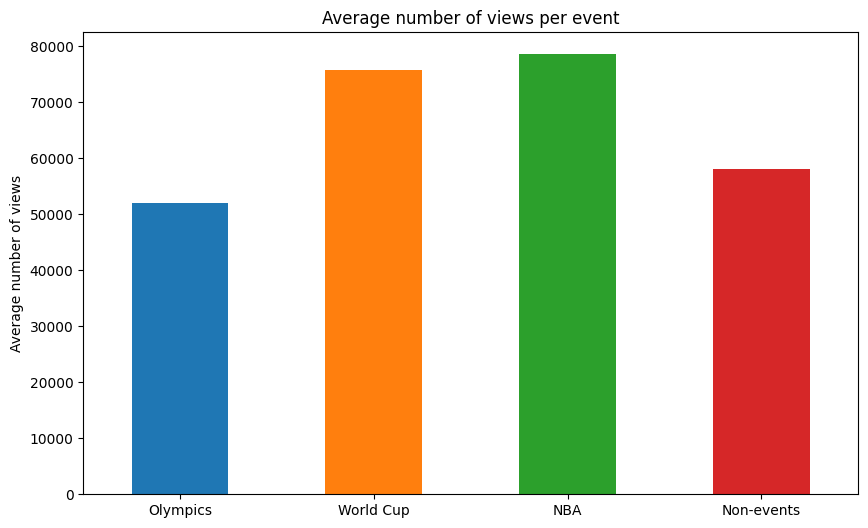

In [71]:
# Average number of views per event
plt.figure(figsize=(10, 6))
colors = sns.color_palette("tab10")
event_views = pd.Series({
    "Olympics": df_olympics["view_count"].mean(),
    "World Cup": df_world_cup["view_count"].mean(),
    "NBA": df_nba["view_count"].mean(),
    "Non-events": df_vd_non_events["view_count"].mean()
})
event_views.plot(kind="bar", color=colors)
plt.title("Average number of views per event")
plt.ylabel("Average number of views")
plt.xticks(rotation=0)
plt.show()

In [72]:
df_olympics["likes_per_view"] = df_olympics["like_count"] / df_olympics["view_count"]
df_world_cup["likes_per_view"] = df_world_cup["like_count"] / df_world_cup["view_count"]
df_nba["likes_per_view"] = df_nba["like_count"] / df_nba["view_count"]

## Sentiment analysis of titles

In [73]:
df_olympics.head(5)

categories                channel_id                  crawl_date  \
index                                                                    
30366     Sports  UCzTfnC661R3LXu_mS9aRFKA  2019-11-04 11:07:21.100437   
49077     Sports  UCzSq7O3MmG-EF0Gq68uSjPw  2019-11-23 14:42:56.211570   
49095     Sports  UCzSq7O3MmG-EF0Gq68uSjPw  2019-11-23 14:43:07.484920   
49105     Sports  UCzSq7O3MmG-EF0Gq68uSjPw  2019-11-23 14:43:13.676141   
49107     Sports  UCzSq7O3MmG-EF0Gq68uSjPw  2019-11-23 14:43:15.000911   

                                             description  dislike_count  \
index                                                                     
30366  For more epic fishing action & tips check out:...            8.0   
49077                                                               0.0   
49095  The organizers of the Olympic Games have been ...            1.0   
49105                                                               0.0   
49107  Iran is hoping that its Olympic team in London...            1.0   

        display_id  duration  like_count  \
index                                      
30366  TOi8me9ijvc        55       171.0   
49077  VoicqeYw_KY       161         5.0   
49095  -JPehFNMNio       151        11.0   
49105  3-PlTZEXnPg       179         4.0   
49107  M8eRQ5hiRJM       123         3.0   

                                                    tags  \
index                                                      
30366  matt watson,new zealand,fishing,fish,ultimate,...   
49077  paralympics,iran,london,press tv,nargess mobal...   
49095  roshan muhammed salih,iran,press tv,mcdonalds,...   
49105  olympic games,olympics,london 2012,amina taylo...   
49107  iran,noshad alamiyan,table_tennis,table_tennis...   

                                           title upload_date  view_count  \
index                                                                      
30366                           MAKO SHARK JUMPS  2018-01-17     19165.0   
49077   Iran's Paralympic team arrives in London  2012-08-29       629.0   
49095  McDonalds dominates London's Olympic Park  2012-08-01      1442.0   
49105           Empty seats blight Olympic Games  2012-07-31       190.0   
49107              Iran aims for Olympic success  2012-07-29       800.0   

                                     title_lower  is_related  \
index                                                          
30366                           mako shark jumps        True   
49077   iran's paralympic team arrives in london        True   
49095  mcdonalds dominates london's olympic park        True   
49105           empty seats blight olympic games        True   
49107              iran aims for olympic success        True   

                                              tags_lower  \
index                                                      
30366  [matt watson, new zealand, fishing, fish, ulti...   
49077  [paralympics, iran, london, press tv, nargess ...   
49095  [roshan muhammed salih, iran, press tv, mcdona...   
49105  [olympic games, olympics, london 2012, amina t...   
49107  [iran, noshad alamiyan, table_tennis, table_te...   

                                       description_lower  likes_per_view  
index                                                                     
30366  for more epic fishing action & tips check out:...        0.008923  
49077                                                           0.007949  
49095  the organizers of the olympic games have been ...        0.007628  
49105                                                           0.021053  
49107  iran is hoping that its olympic team in london...        0.003750

In [74]:
# Faster method

analyzer = SentimentIntensityAnalyzer()

def get_sentiment_label(text: str) -> str:
    result = analyzer.polarity_scores(text)
    label = np.argmax([result["neg"], result["neu"], result["pos"]])
    if label == 0:
        return "negative"
    elif label == 1:
        return "neutral"
    else:
        return "positive"

In [75]:
text = "Highlight of the match between France and Germany in the 2014 World Cup."
print(analyzer.polarity_scores(text))
print(get_sentiment_label(text))

{'neg': 0.0, 'neu': 0.833, 'pos': 0.167, 'compound': 0.34}
neutral


In [86]:
df_olympics["title_sentiment"] = df_olympics["title"].apply(get_sentiment_label)
df_world_cup["title_sentiment"] = df_world_cup["title"].apply(get_sentiment_label)
df_nba["title_sentiment"] = df_nba["title"].apply(get_sentiment_label)

In [87]:
def plot_sentiment_distribution(df: pd.DataFrame, title: str):
    plt.figure(figsize=(6, 6))
    colors = ["#ff9999", "#99ff99", "#66b3ff"]  # Map to negative, neutral, positive
    # Create a palette dictionary to ensure consistent mapping
    palette = dict(zip(["negative", "neutral", "positive"], colors))
    sns.countplot(
        x="title_sentiment", 
        data=df, 
        order=["negative", "neutral", "positive"],
        palette=palette  # Use the mapped palette
    )
    plt.xlabel("")
    plt.ylabel("Count")
    plt.yscale("log")
    plt.title(title)
    plt.show()

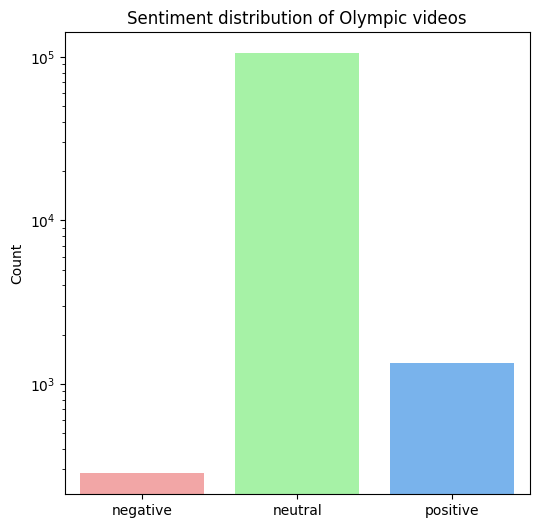

In [88]:
plot_sentiment_distribution(df_olympics, "Sentiment distribution of Olympic videos")

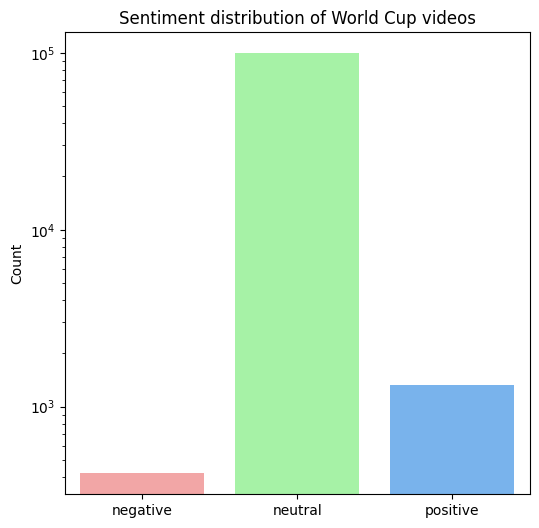

In [89]:
plot_sentiment_distribution(df_world_cup, "Sentiment distribution of World Cup videos")

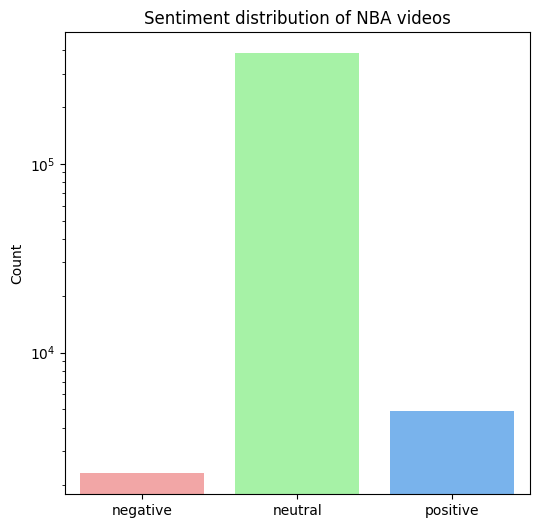

In [90]:
plot_sentiment_distribution(df_nba, "Sentiment distribution of NBA videos")

## Difference in difference

In [14]:
df_ch_ts_olympics = pd.merge(df_ts_f, df_olympics, left_on="channel",  right_on="channel_id", how="inner")

Missing values
 delta_views                     0
is_sports                       0
Rio_de_jainero_olympics_2016    0
interaction                     0
dtype: int64


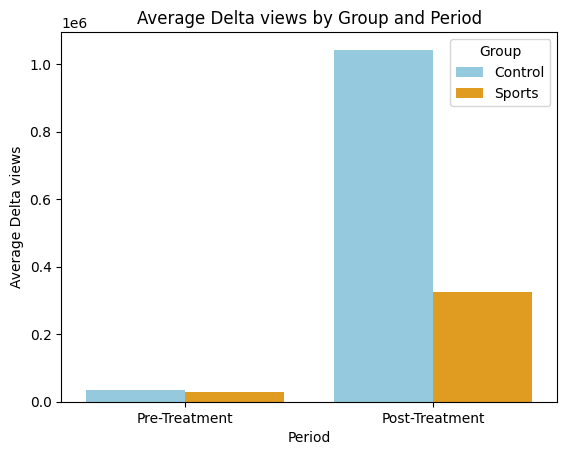

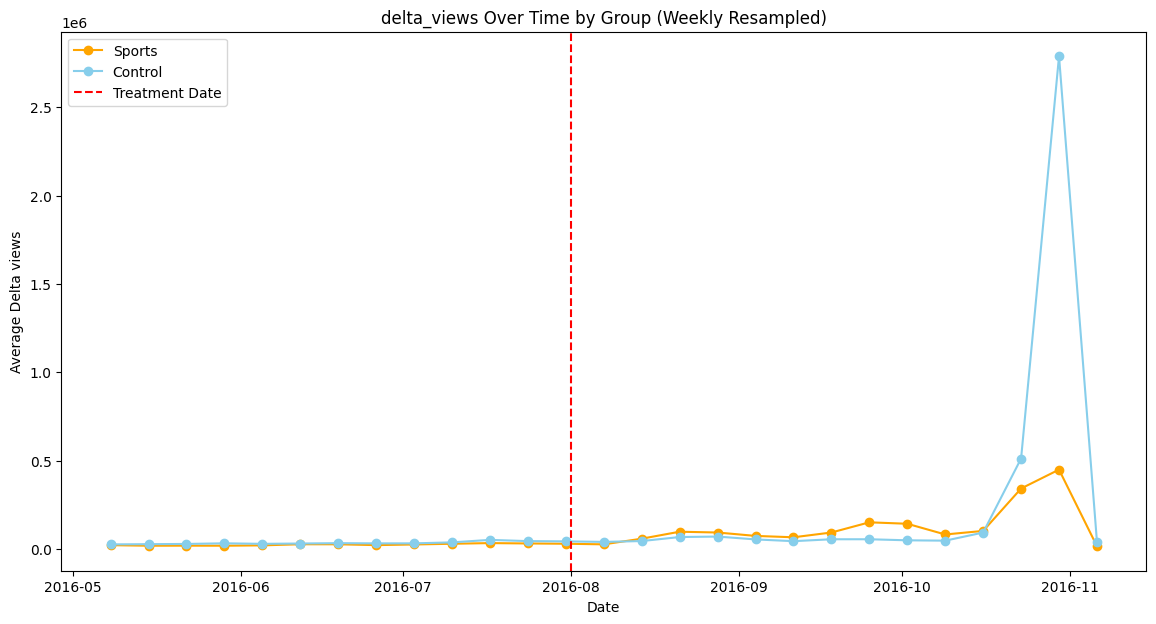

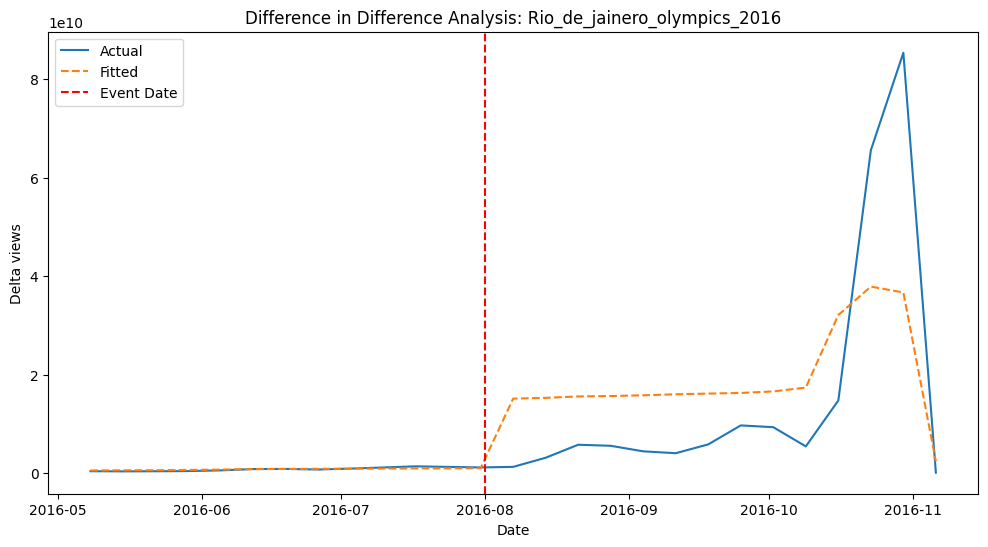

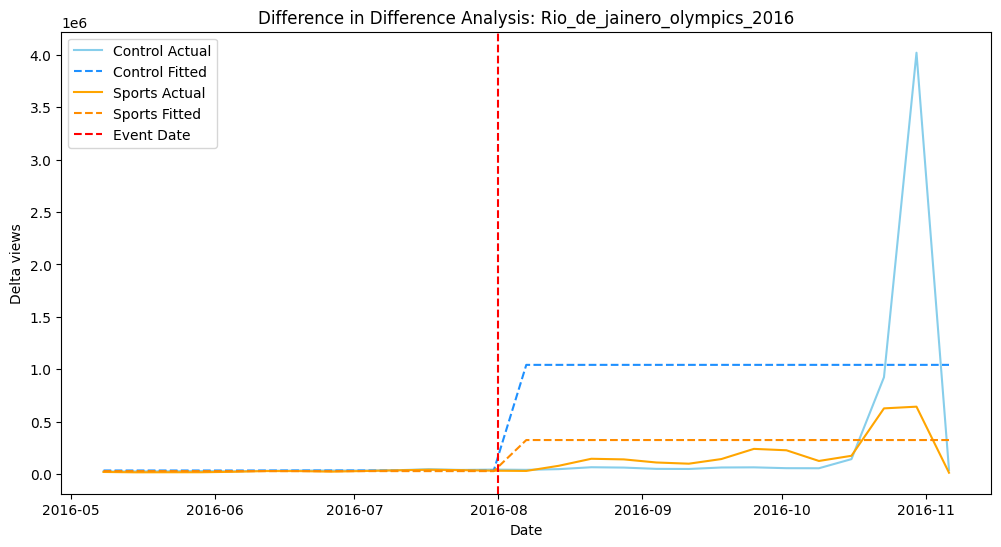

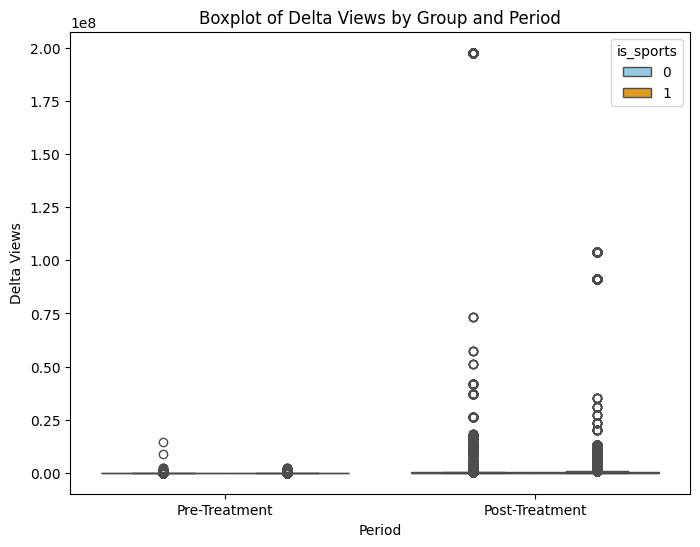

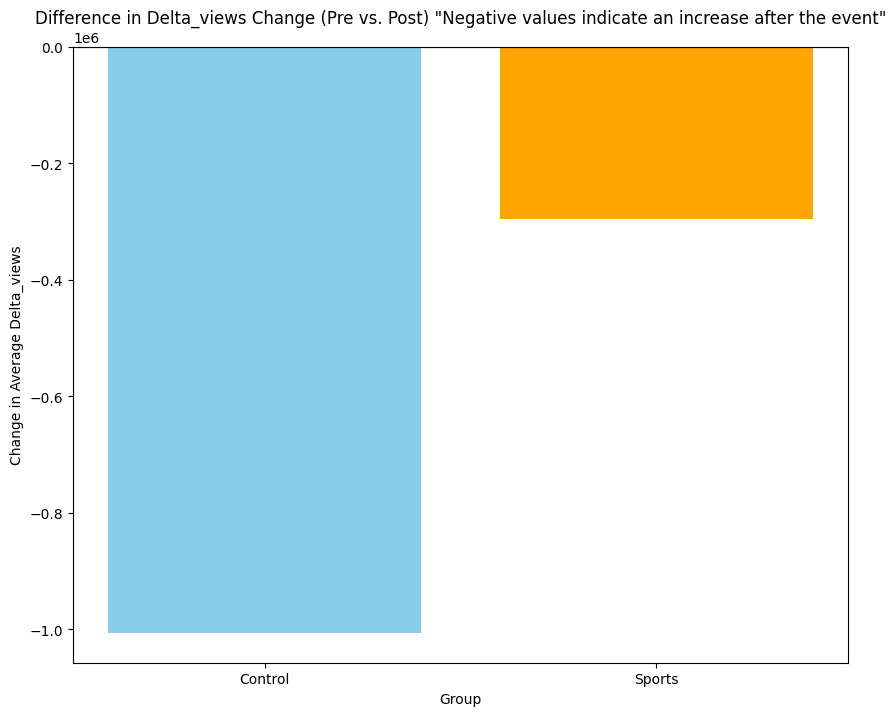

                            OLS Regression Results                            
Dep. Variable:            delta_views   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1974.
Date:                Fri, 15 Nov 2024   Prob (F-statistic):               0.00
Time:                        23:35:49   Log-Likelihood:            -1.8944e+07
No. Observations:             1156918   AIC:                         3.789e+07
Df Residuals:                 1156914   BIC:                         3.789e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [16]:
diff_in_diff(
    df_ch_ts_olympics, 
    "datetime", 
    "delta_views", 
    pd.to_datetime('2016-08'), 
    'Rio_de_jainero_olympics_2016', 
    3
)

# Part 3: Sport-based analysis

We will analyze the frequency of popular sports tags in a dataset by visualizing their occurrence. This involves counting how often each sport appears in the tags, focusing on a predefined list of popular sports, and then plotting these counts as a bar chart to identify trends or dominant sports.

Note that “football” can refer to both soccer and American football, making it a vague term. In future analyses, we will use NLP techniques to clarify the specific category of videos associated with such ambiguous tags.

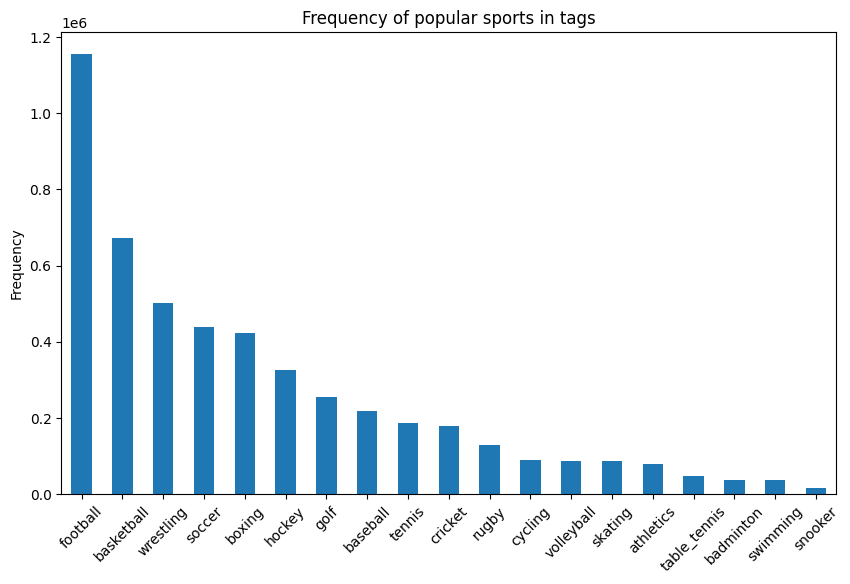

In [20]:
# Frequency of sports in tags
tag_counts = Counter(all_tags_sport)

popular_sports = [
    "soccer", "football", "cricket", "hockey", 
    "tennis", "volleyball", "baseball", "rugby", 
    "golf", "snooker", "basketball", "skating",
    "swimming", "wrestling", "table_tennis", "badminton",
    "cycling", "boxing", "athletics"
]

popular_sports_counts = {sport: tag_counts[sport] for sport in popular_sports}

plt.figure(figsize=(10, 6))
popular_sports_counts_series = pd.Series(popular_sports_counts)
popular_sports_counts_series.sort_values(ascending=False).plot(kind="bar")
plt.title("Frequency of popular sports in tags")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

# Part 4: User engagement

In [ ]:
def preprocess(df_video):
    """
    Prepare the video dataset for analysis
    - Change the upload_date to datetime
    - Extract year, month, day from the upload_date
    - Convert the tags into the ones with only small letters
    """
    df_video["upload_date"] = pd.to_datetime(df_video["upload_date"], format="%Y-%m-%d %H:%M:%S")
    df_video["year"] = df_video["upload_date"].dt.year
    df_video["month"] = df_video["upload_date"].dt.month
    df_video["day"] = df_video["upload_date"].dt.day

    # convert the tags into the ones with only small letters
    df_video["tags"] = df_video["tags"].apply(lambda x: x.lower())

    return df_video


def add_sports_category(df_video, category_sports):
    """
    Add a new column for each sports category that indicates whether the video is related to that category
    """
    for s in category_sports:
        df_video[f"is_{s}"] = (df_video.tags.str.contains(s))
    df_video["is_other"] = 1 - df_video[[f"is_{s}" for s in category_sports]].any(axis=1)
    df_video["is_other"] = df_video["is_other"].astype(bool)

    return df_video


def add_point_for_each_sports(df_video, category_sports):
    """
    Add a new column for each sports category that represents how much the video is related to that category. 
    If the video is related to multiple categories, the point is divided equally among those categories.
    For example, if a video is related to basketball and soccer, the point for basketball and soccer is 0.5.
    """
    df_video["num_category"] = df_video[[f"is_{s}" for s in category_sports + ["other"]]].sum(axis=1)
    for s in category_sports:
        df_video[f"point_{s}"] = df_video[f"is_{s}"].astype(int) / df_video["num_category"]

    # drop the "num_category" column
    df_video = df_video.drop(columns=["num_category"])

    return df_video


category_sports = [
    "basketball", 
    "wrestling", 
    "soccer", 
    "boxing", 
    "hockey", 
    "golf", 
    "baseball",
]


df_video_sports = preprocess(df_vd_sports)
df_video_sports = add_sports_category(df_video_sports, category_sports)
df_video_sports = add_point_for_each_sports(df_video_sports, category_sports)

df_video_sports.head()

categories                channel_id                  crawl_date  \
index                                                                    
1292      Sports  UCzWn_gTaXyH5Idyo8Raf7_A  2019-11-03 16:39:57.427254   
1293      Sports  UCzWn_gTaXyH5Idyo8Raf7_A  2019-11-03 16:39:58.108323   
1294      Sports  UCzWn_gTaXyH5Idyo8Raf7_A  2019-11-03 16:39:58.773085   
1295      Sports  UCzWn_gTaXyH5Idyo8Raf7_A  2019-11-03 16:39:59.465346   
1296      Sports  UCzWn_gTaXyH5Idyo8Raf7_A  2019-11-03 16:40:00.188768   

                                             description  dislike_count  \
index                                                                     
1292   Can I catch 100 lbs of catfish LIVE. Me and Ja...           35.0   
1293                                                               15.0   
1294   Are you ready to enter the high fashion world ...           78.0   
1295   Saltwater fishing out of Newquay Cornwall UK. ...           70.0   
1296   My family spent 3 weeks touring England and fi...           73.0   

        display_id  duration  like_count  \
index                                      
1292   JOeSxtcNdHQ      8620      1673.0   
1293   EPMLTw2zINw       355      1297.0   
1294   Y1_pK68iSYQ       603      3305.0   
1295   jF8TSo3ZfTc      1426      1889.0   
1296   Gp00dNaVouo       990      2699.0   

                                                    tags  \
index                                                      
1292   catfishing,fishing,fishing challenge,catfish,c...   
1293                                                       
1294   catfishing,how to catch catfish,fishing,classy...   
1295   fishing,fishing uk,angling,sea angling,sea ang...   
1296   fishing,catfish,wels catfish,how to catch catf...   

                                                   title  ... is_baseball  \
index                                                     ...               
1292                   Catching 100 lbs of Catfish 🔴Live  ...       False   
1293                                             big cat  ...       False   
1294   Classy Catfishing - How to Catch Catfish the P...  ...       False   
1295   2 Day Saltwater Fishing Catch & Cook - UK Sea ...  ...       False   
1296   How to Catch Wels Catfish - Fishing for Catfis...  ...       False   

       is_other  num_category  point_basketball  point_wrestling  \
index                                                              
1292       True             1               0.0              0.0   
1293       True             1               0.0              0.0   
1294       True             1               0.0              0.0   
1295       True             1               0.0              0.0   
1296       True             1               0.0              0.0   

       point_soccer  point_boxing  point_hockey  point_golf  point_baseball  
index                                                                        
1292            0.0           0.0           0.0         0.0             0.0  
1293            0.0           0.0           0.0         0.0             0.0  
1294            0.0           0.0           0.0         0.0             0.0  
1295            0.0           0.0           0.0         0.0             0.0  
1296            0.0           0.0           0.0         0.0             0.0  

[5 rows x 31 columns]

In [84]:
df_comment_points_by_sports_by_author = pd.DataFrame()

# Load the comment datasaet in batches (The maximum is 100_000_000)
for i in range(10):
    print(f"Batch {i}:", end=" ")
    # load the comment dataset in batches
    df_co_f_batch = pd.read_csv(
        os.path.join(DATA_PATH, "youtube_comments.tsv"), 
        sep="\t", 
        skiprows=range(1, i * 10_000_000), 
        nrows=1_000_000
    )
    print(len(df_co_f_batch))

    # merge the two dataframes with "video_id" and "display_id" as the common column
    df_merged_batch = pd.merge(df_co_f_batch, df_video_sports, left_on="video_id", right_on="display_id")
    df_comment_points_by_sports_by_author_batch = df_merged_batch[["author"] + [f"point_{s}" for s in category_sports]].groupby("author").sum()

    # Add a column for all sports
    df_comment_points_by_sports_by_author_batch["point_all_sports"] = df_merged_batch.groupby("author").count().video_id

    # Add a column for other sports
    df_comment_points_by_sports_by_author_batch["point_other_sports"] = \
        df_comment_points_by_sports_by_author_batch["point_all_sports"] - df_comment_points_by_sports_by_author_batch[[f"point_{s}" for s in category_sports]].sum(axis=1)

    # Filter out authors with less than 100 comments
    df_comment_points_by_sports_by_author_batch = df_comment_points_by_sports_by_author_batch[df_comment_points_by_sports_by_author_batch[[f"point_{s}" for s in category_sports]].sum(axis=1) >= 100]

    df_comment_points_by_sports_by_author = pd.concat([df_comment_points_by_sports_by_author, df_comment_points_by_sports_by_author_batch])

    del df_co_f_batch
    del df_merged_batch
    del df_comment_points_by_sports_by_author_batch

Batch 0: 1000000
Batch 1: 1000000
Batch 2: 1000000
Batch 3: 1000000
Batch 4: 1000000
Batch 5: 1000000
Batch 6: 1000000
Batch 7: 1000000
Batch 8: 1000000
Batch 9: 1000000


In [89]:
df_comment_points_by_sports_by_author

point_basketball  point_wrestling  point_soccer  point_boxing  \
author                                                                   
2990             0.000000            310.5           0.0           0.5   
5456             0.000000              0.0           0.0           0.5   
9025             4.000000             55.0          62.0           3.0   
16912            0.000000              6.0        1098.5           0.5   
25098            0.000000            131.0          24.0           3.0   
...                   ...              ...           ...           ...   
6049149          0.000000            136.0           0.0           0.0   
6057637         87.000000             29.0           0.0           5.0   
6071415          1.000000            105.0           0.0           2.0   
6073242         96.000000             66.5           0.0           0.0   
6080078          0.333333              0.0           0.0           0.0   

         point_hockey  point_golf  point_baseball  point_all_sports  \
author                                                                
2990         0.000000         0.0        0.000000               339   
5456         0.000000       131.5        0.000000               135   
9025         0.000000         0.0        0.000000               481   
16912        0.000000        34.0        0.000000             15441   
25098        0.000000         1.0        0.000000               226   
...               ...         ...             ...               ...   
6049149      0.000000         0.0        0.000000               143   
6057637      0.000000         1.0        0.000000               230   
6071415      0.000000         0.0        0.000000               155   
6073242      0.000000         0.5        0.000000               237   
6080078    101.333333         0.0        0.333333               118   

         point_other_sports  
author                       
2990                   28.0  
5456                    3.0  
9025                  357.0  
16912               14302.0  
25098                  67.0  
...                     ...  
6049149                 7.0  
6057637               108.0  
6071415                47.0  
6073242                74.0  
6080078                16.0  

[148 rows x 9 columns]

/var/folders/qs/8z9xcm210_n3npgpj0yx6_k00000gn/T/ipykernel_82901/800734296.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  (df_comment_points_by_sports_by_author[[f"point_{s}" for s in category_sports]]).apply(lambda x: x + 1).applymap(lambda x: np.log10(x)),


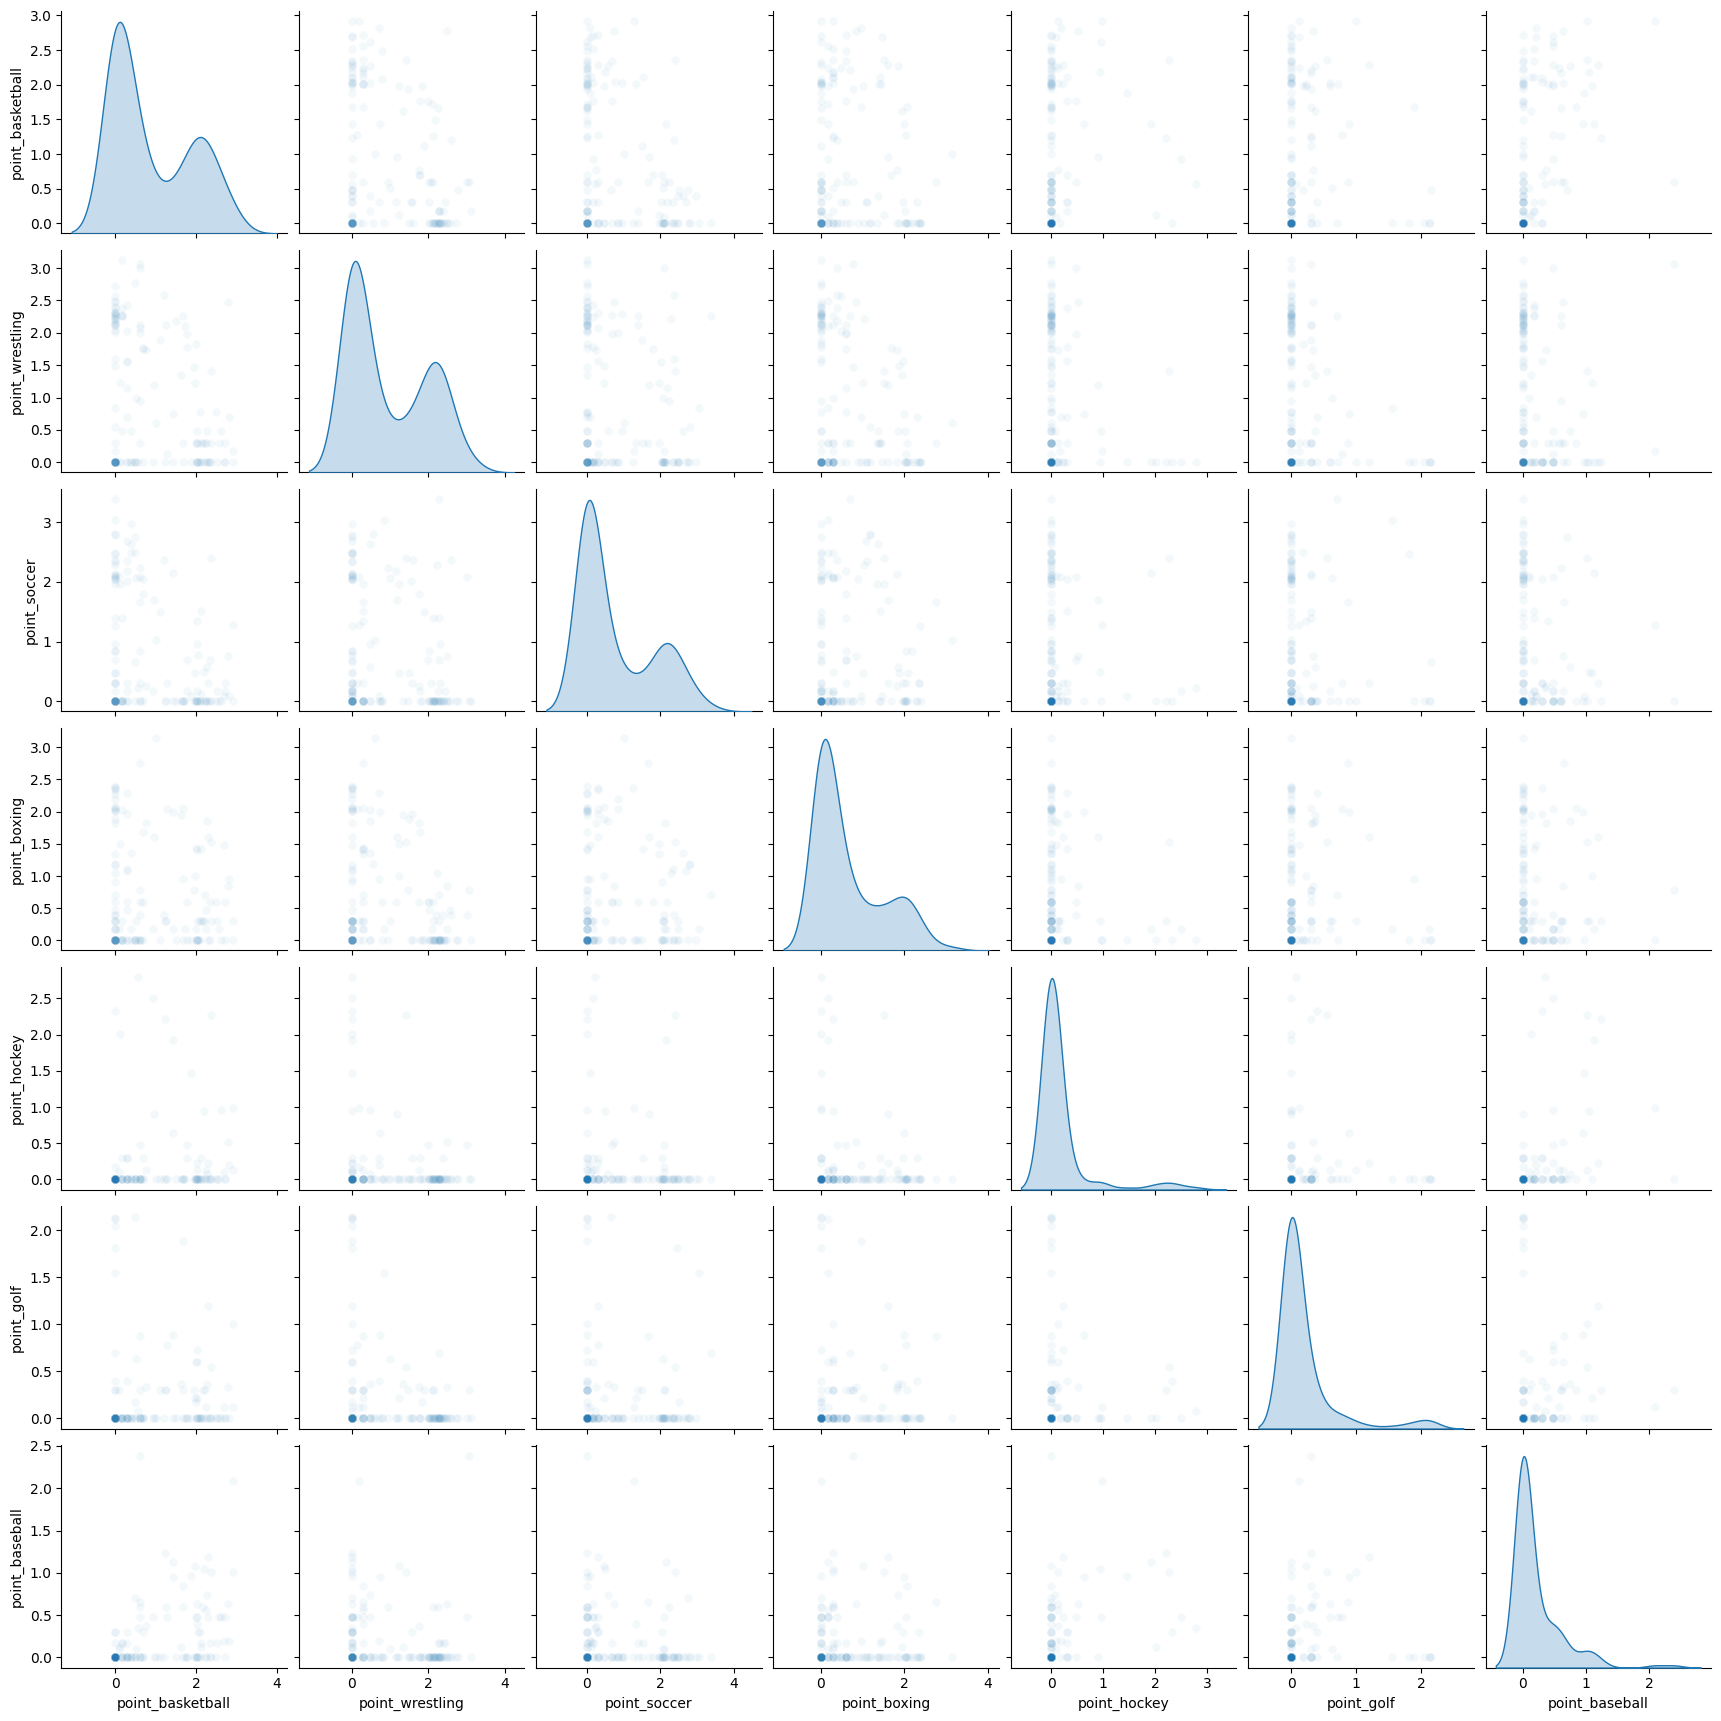

In [85]:
# plot the scatter plot for all pairs of sports (log scale)

# scatter plot
sns.pairplot(
    (df_comment_points_by_sports_by_author[[f"point_{s}" for s in category_sports]]).apply(lambda x: x + 1).applymap(lambda x: np.log10(x)),
    diag_kind="kde", 
    hue_order=category_sports,
    plot_kws={"alpha": 0.05}
)

/var/folders/qs/8z9xcm210_n3npgpj0yx6_k00000gn/T/ipykernel_82901/1674838644.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  (df_comment_points_by_sports_by_author[[f"point_{s}" for s in category_sports]]).apply(lambda x: x + 1).applymap(lambda x: np.log10(x)),


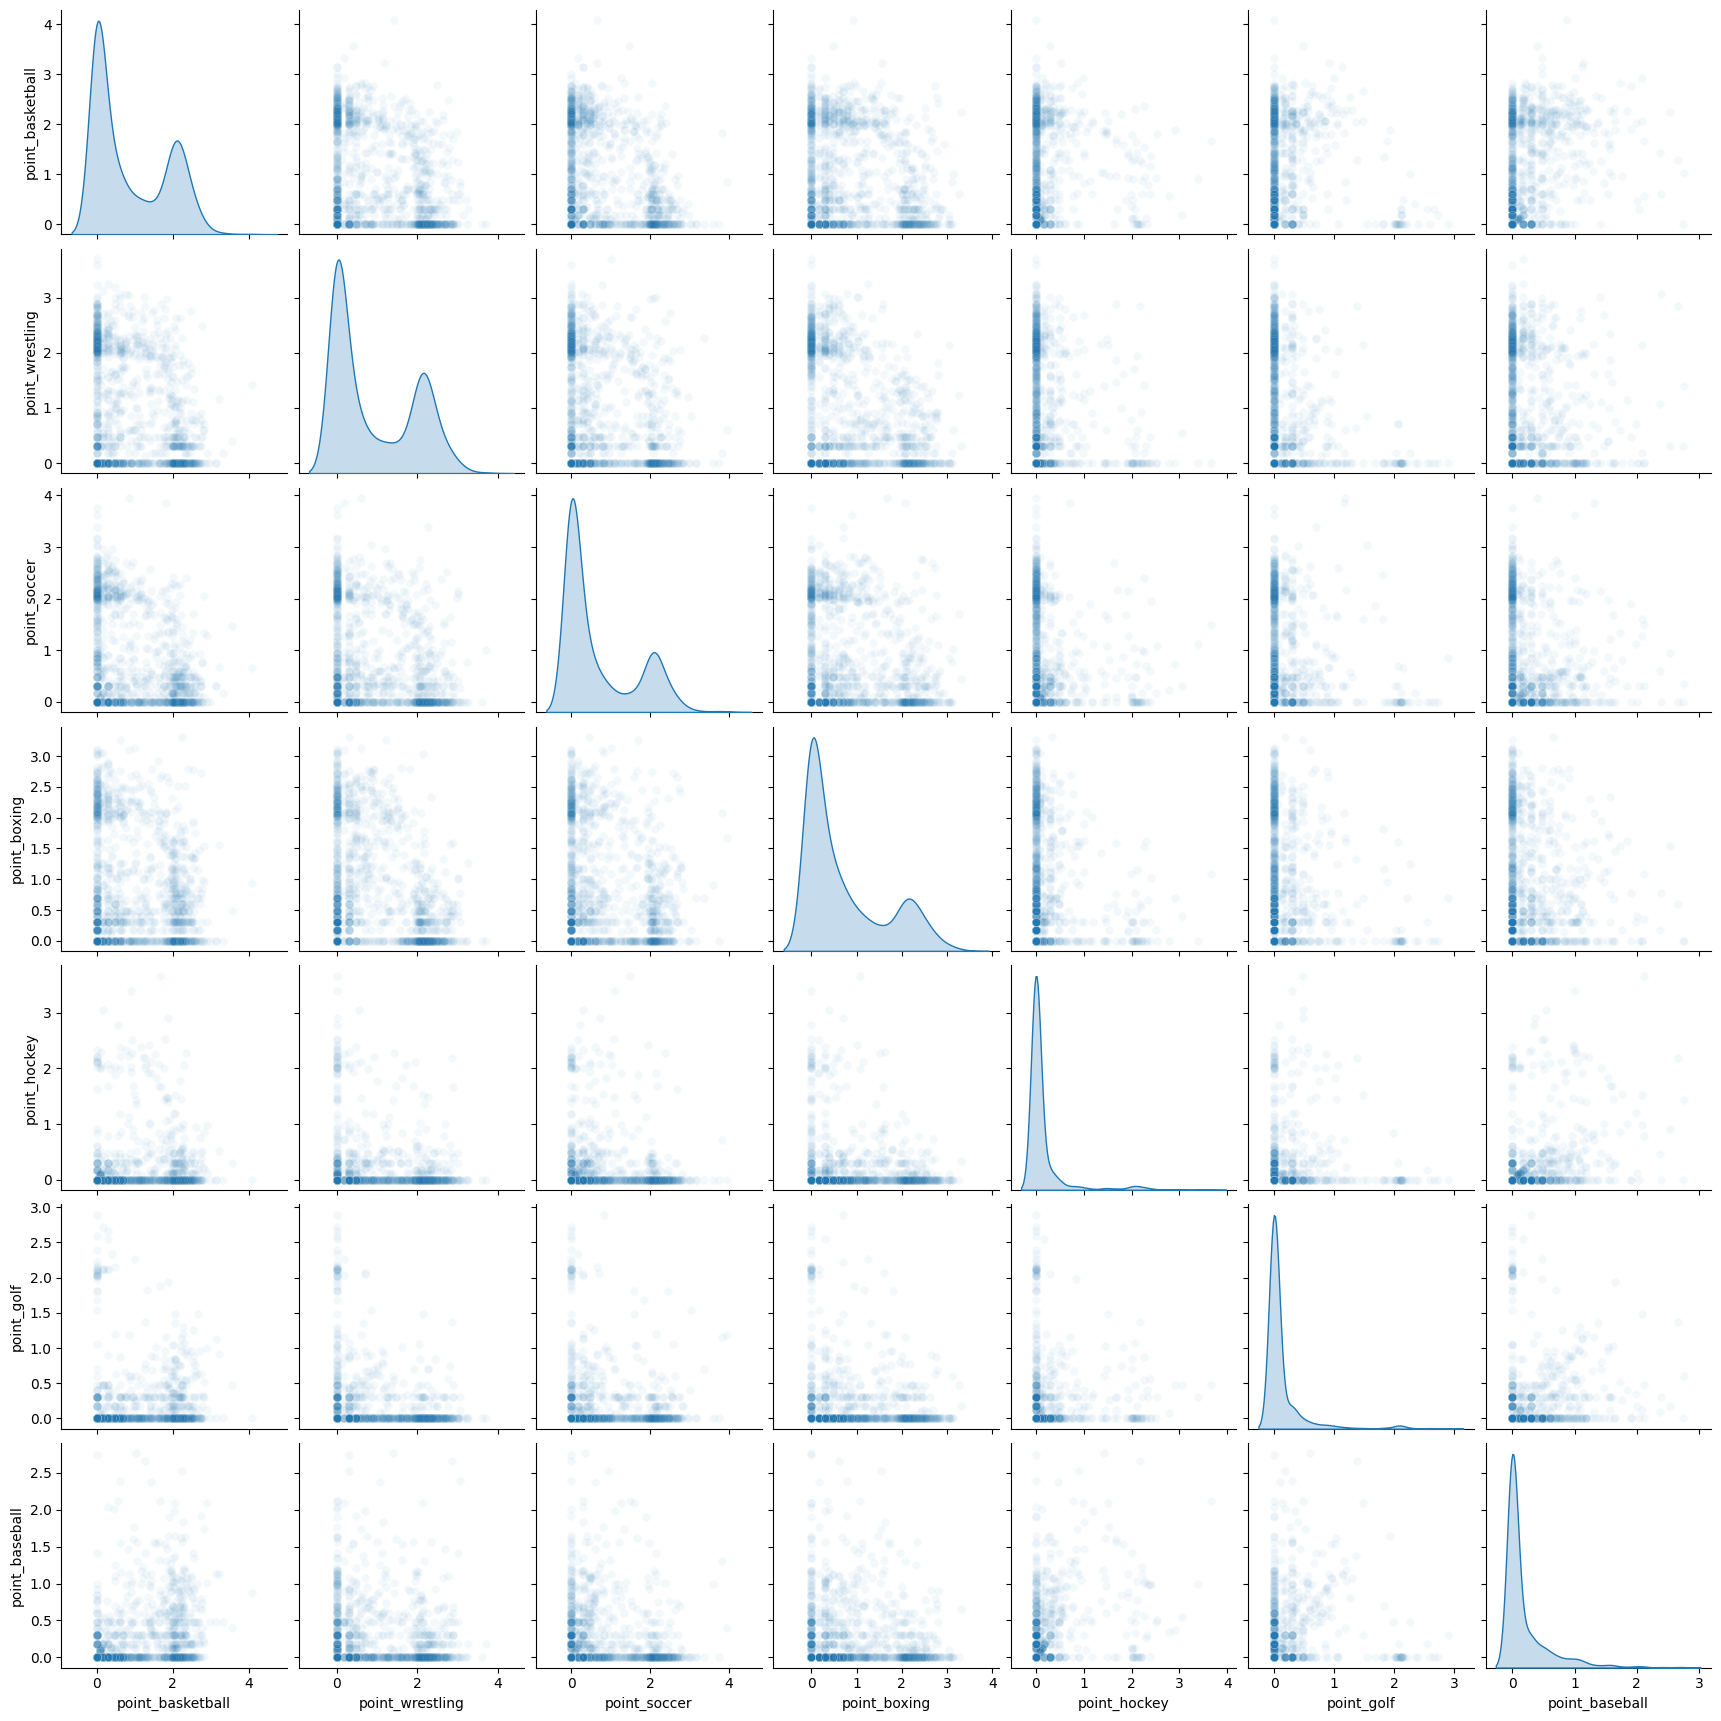

In [ ]:
# plot the scatter plot for all pairs of sports (log scale)

# scatter plot
sns.pairplot(
    (df_comment_points_by_sports_by_author[[f"point_{s}" for s in category_sports]]).apply(lambda x: x + 1).applymap(lambda x: np.log10(x)),
    diag_kind="kde", 
    hue_order=category_sports,
    plot_kws={"alpha": 0.05}
)

The above graph illustrates the correlation of interest among fans of various major sports. For this analysis, “fans” are defined as users who comment on videos related to a specific sport.

The diagonal graphs show the distribution of comments per user for each sport. The x-axis represents the “intensity” of fandom (i.e., the number of comments), and the y-axis shows the corresponding number of fans.

Starting with the diagonal graphs, basketball, wrestling, soccer, and boxing display bimodal distributions, indicating two distinct user groups: those with moderate interest and those with intense interest in these sports. Conversely, hockey, golf, and baseball show a less prominent second peak, suggesting lower engagement on YouTube. This could be attributed to these sports being popular only in certain regions. A more detailed analysis will be conducted in Milestone 3.

Next, the off-diagonal graphs are analyzed. For instance, the graph in the second column and first row represents the correlation between basketball and wrestling fans (i.e., whether basketball fans are also wrestling fans). The darker areas are concentrated in three regions: bottom-right, bottom-left, and top-right. These correspond to users who are basketball fans but not wrestling fans, users who are fans of neither sport, and users who are wrestling fans but not basketball fans, respectively. Notably, there are few users in the top-right corner, representing fans of both basketball and wrestling.

This clustering method allows for the segmentation of fans by sport. The analysis for Milestone 3 will extend this method to more sports. Additionally, by segmenting data based on the upload dates of videos, the evolution of fan bases (i.e., users commenting on videos related to specific sports) will be observed. Particular attention will be given to major sporting events, such as the Olympics, to analyze how these events impact fan engagement for different sports.